In [164]:
!pip install category_encoders feature_engine kaleido scikit-learn-intelex shap > /dev/null

In [232]:
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import category_encoders as ce

# from feature_engine.imputation import RandomSampleImputer

# sklearn imports
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import estimator_html_repr
from sklearn_pandas import DataFrameMapper
from sklearnex import patch_sklearn
patch_sklearn()

# plotly imports
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot

# warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

# Display images
from IPython.display import Image

# Plotly rendering (work around Plotly rendering issues with GitHub)
pio.renderers.default = "svg"

# Plotly rendering for Google Coab
# pio.renderers.default = "colab"

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [170]:
df = pd.read_csv('data/Airline_customer_satisfaction.csv')

In [171]:
%%html
<style>
table {align:left;display:block}
</style>

|Column name	                  | Description                                                                |
|:------------------------------- |:-------------------------------------------------------------------------- |   
|Satisfaction	                  |Indicates the satisfaction level of the customer.                           |
|Customer Type	                  |Type of customer: 'Loyal Customer' or 'Disloyal Customer’.                  |
|Age	                          |Age of the customer.                                                        |
|Type of Travel	                  |Purpose of the travel: 'Business travel' or 'Personal Travel’.              |
|Class	                          |Class of travel: 'Business', 'Eco', or 'Eco Plus’.                          |
|Flight Distance	              |The distance of the flight in kilometres                                    |
|Seat comfort	                  |Rating of seat comfort provided during the flight (0:Not Applicable;1-5).   |
|Departure/Arrival time convenient|	Rating of the convenience of departure/arrival time (0:Not Applicable;1-5).|
|Food and drink	Rating            |of food and drink quality provided during the flight (0:Not Applicable;1-5).|
|Gate location	Rating            |of gate location convenience (0:Not Applicable;1-5).                        |
|Inflight wifi service            |Rating of inflight wifi service satisfaction (0:Not Applicable;1-5).        |
|Inflight entertainment           |Rating of inflight entertainment satisfaction (0:Not Applicable;1-5).       |
|Online support	                  |Rating of online customer support satisfaction (0:Not Applicable;1-5).      |
|Ease of Online booking	          |Rating of ease of online booking satisfaction ((0:Not Applicable;1-5).      |
|On-board service	              |Rating of on-board service satisfaction (0:Not Applicable;1-5).             |
|Leg room service	              |Rating of leg room service satisfaction (0:Not Applicable;1-5).             |
|Baggage handling	              |Rating of baggage handling satisfaction (0:Not Applicable;1-5).             |
|Checkin service	              |Rating of check-in service satisfaction (0:Not Applicable;1-5).             |
|Cleanliness	                  |Rating of cleanliness satisfaction (0:Not Applicable;1-5).                  |
|Online boarding	              |Rating of online boarding satisfaction (0:Not Applicable;1-5).              |
|Departure Delay in Minutes       |Total departure delay in minutes.                                           |
|Arrival Delay in Minutes	      |Total arrival delay in minutes.                                             |

In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Customer Type                      129880 non-null  object 
 2   Age                                129880 non-null  int64  
 3   Type of Travel                     129880 non-null  object 
 4   Class                              129880 non-null  object 
 5   Flight Distance                    129880 non-null  int64  
 6   Seat comfort                       129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Food and drink                     129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Inflight wifi service              129880 non-null  int64  
 11  Inflight entertainment             1298

We can notice that there are some missing values for `Arrival Delay in Minutes`,  we wil impute them later.

In [173]:
df.head(5)

satisfaction   Customer Type  Age   Type of Travel     Class  \
0    satisfied  Loyal Customer   65  Personal Travel       Eco   
1    satisfied  Loyal Customer   47  Personal Travel  Business   
2    satisfied  Loyal Customer   15  Personal Travel       Eco   
3    satisfied  Loyal Customer   60  Personal Travel       Eco   
4    satisfied  Loyal Customer   70  Personal Travel       Eco   

   Flight Distance  Seat comfort  Departure/Arrival time convenient  \
0              265             0                                  0   
1             2464             0                                  0   
2             2138             0                                  0   
3              623             0                                  0   
4              354             0                                  0   

   Food and drink  Gate location  ...  Online support  Ease of Online booking  \
0               0              2  ...               2                       3   
1               0              3  ...               2                       3   
2               0              3  ...               2                       2   
3               0              3  ...               3                       1   
4               0              3  ...               4                       2   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 3                 0                 3                5   
1                 4                 4                 4                2   
2                 3                 3                 4                4   
3                 1                 0                 1                4   
4                 2                 0                 2                4   

   Cleanliness  Online boarding  Departure Delay in Minutes  \
0            3                2                           0   
1            3                2                         310   
2            4                2                           0   
3            1                3                           0   
4            2                5                           0   

   Arrival Delay in Minutes  
0                       0.0  
1                     305.0  
2                       0.0  
3                       0.0  
4                       0.0  

[5 rows x 22 columns]

### Data Prep

#### Cleaning Nulls

In [174]:
# Finding which columns have null values
null_counts = df.isnull().sum()
null_counts[null_counts > 0]

Arrival Delay in Minutes    393
dtype: int64

In [175]:
# Filter columns with null values
columns_with_nulls = null_counts[null_counts > 0].index.tolist()

# Initialize SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on columns with null values
df[columns_with_nulls] = imputer.fit_transform(df[columns_with_nulls])

In [176]:

# Check if there're any null values left
null_counts = df.isnull().sum()
columns_with_nulls = null_counts[null_counts > 0]
print(f'Count of columns will null values: {len(columns_with_nulls)}')

Count of columns will null values: 0


In [177]:
print('Duplicates:', df.duplicated().sum())

Duplicates: 0


## Understanding the Features

### Target feature distribution
Lets have a look at the distribution of `satisfaction` - the target classification feature

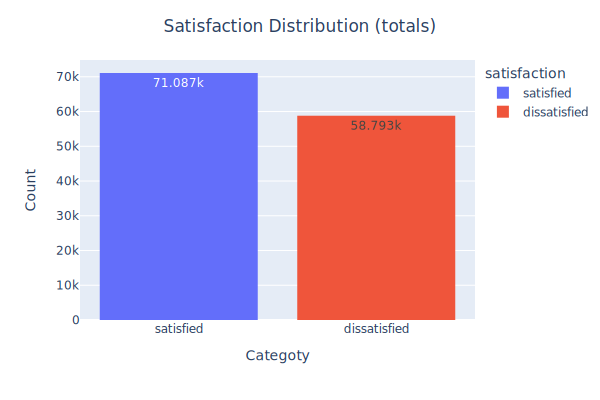

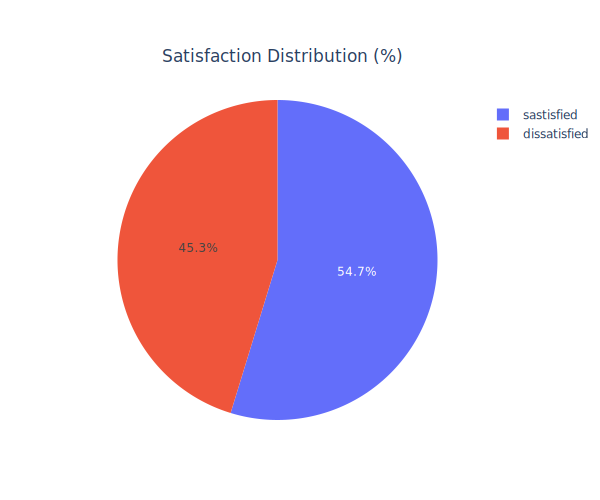

In [178]:
fig = px.histogram(df, x='satisfaction', color='satisfaction', text_auto=True)
fig.update_layout(title='Satisfaction Distribution (totals)',
                  title_x=0.5, title_y=0.95,
                  width=600, height=400,
                  yaxis_title='Count',
                  xaxis_title='Categoty')

fig.write_image("img/distribution.png")

fig.show()
labels = ['sastisfied','dissatisfied']
values = [54.733, 45.267]

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title='Satisfaction Distribution (%)',   title_x=0.27, title_y=0.9, width=600)
fig.show()

In [179]:
satisfied =  len(df[df["satisfaction"] == "satisfied"]) / len(df)
dissatisfied = len(df[df["satisfaction"] == "dissatisfied"]) / len(df)
print(f'Satisfaction Distribution:')
print(f'sastisfied:   {satisfied*100:.3f}%')
print(f'dissatisfied: {dissatisfied*100:.3f}%')

Satisfaction Distribution:
sastisfied:   54.733%
dissatisfied: 45.267%


We can see that the target feature `satisfaction` is quite balanced, so there is no need to perform operations to balance it

### Numerical Features

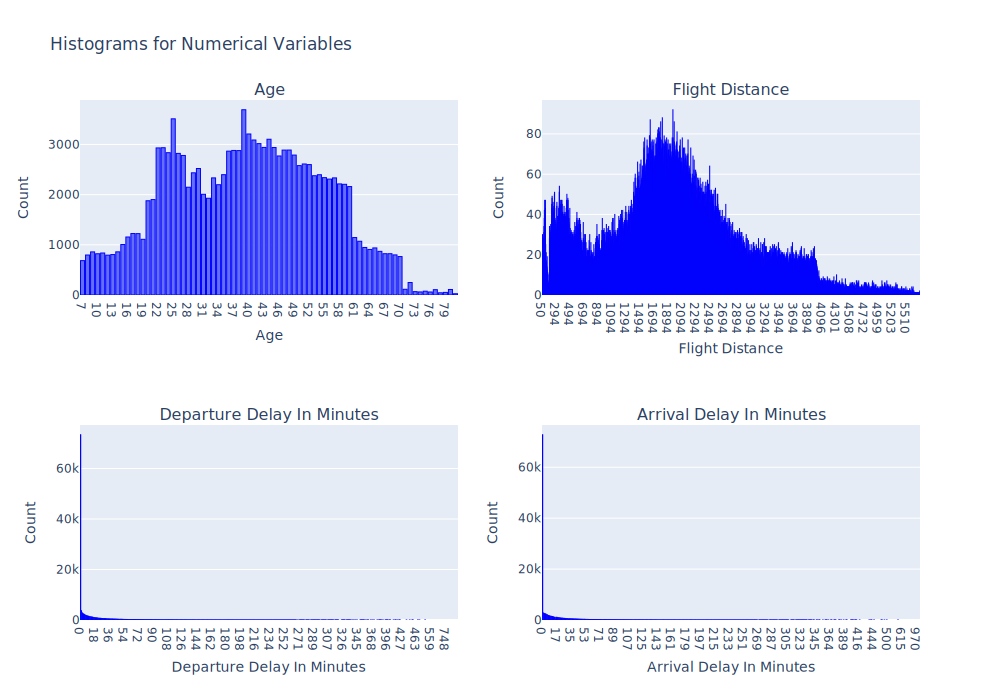

In [180]:
columns = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

dimension = math.ceil(np.sqrt(len(columns)))
fig = make_subplots(cols = dimension, rows = dimension, subplot_titles=(list(map(lambda x: x.replace('_', " ").title(), columns))))

for i, column in enumerate(columns):
    row = math.floor((i + dimension) / dimension)
    col = ((i + dimension) % dimension) + 1

    fig.add_histogram(x = np.sort(df[column]), row = row, col = col, showlegend=False)

    fig['layout'][f'xaxis{i+1}']['title'] = column.replace('_', " ").title()
    fig['layout'][f'yaxis{i+1}']['title'] = 'Count'

    fig.update_traces(marker_line_width=1,marker_line_color="blue")

fig.update_layout(height=700, width=1000, title_text="Histograms for Numerical Variables")
fig.update_xaxes(type='category')
fig.show()

:bulb: We can see that Departure and Arrival in Minutes columns have some outliers, We'll remove them later.

We'll explore the numerical features against satisfaction breakdown

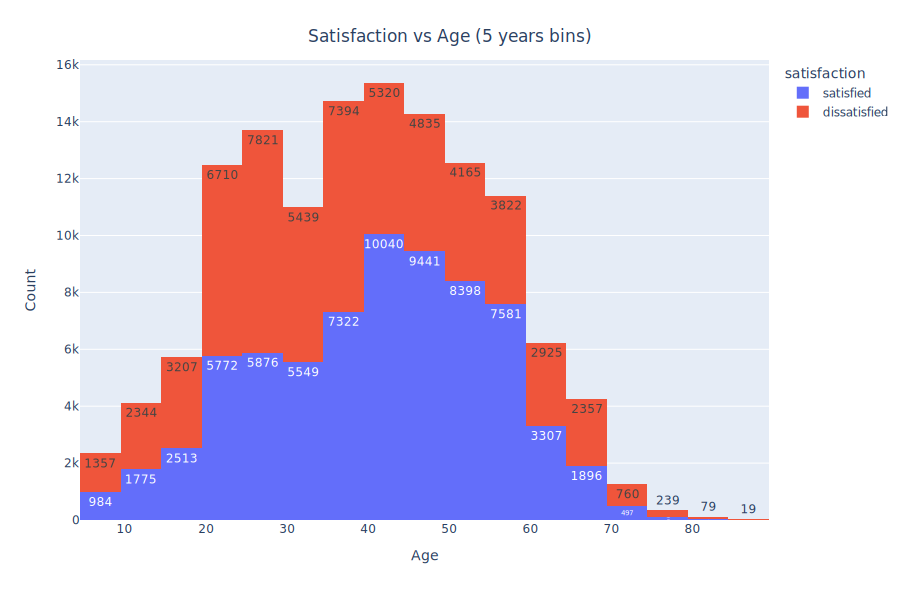

In [181]:
fig = px.histogram(df, x='Age', color='satisfaction', nbins=20, text_auto='.0f')
fig.update_layout(title='Satisfaction vs Age (5 years bins)',
                  title_x=0.5, title_y=0.95,
                  height=600, width=900,
                  yaxis_title='Count',
                  xaxis_title='Age').show()

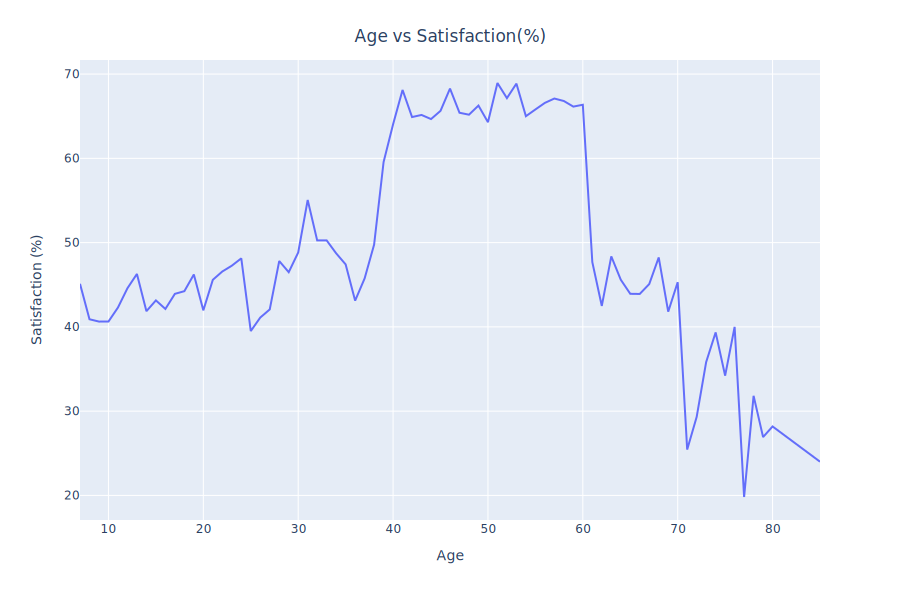

In [182]:
age_grouped = df.groupby('Age')['satisfaction'].value_counts(normalize=True).unstack()
age_satisfied = age_grouped['satisfied'] * 100
fig = px.line(x=age_satisfied.index, y=age_satisfied.values, labels={'x': 'Age', 'y': 'Satisfaction (%)'})
fig.update_layout(title='Age vs Satisfaction(%)', title_x=0.5, title_y=0.95, height=600, width=900).show()

We can see that satisfaction is higher when Age > 45. Customers younger than 40 showed less satisfaction.

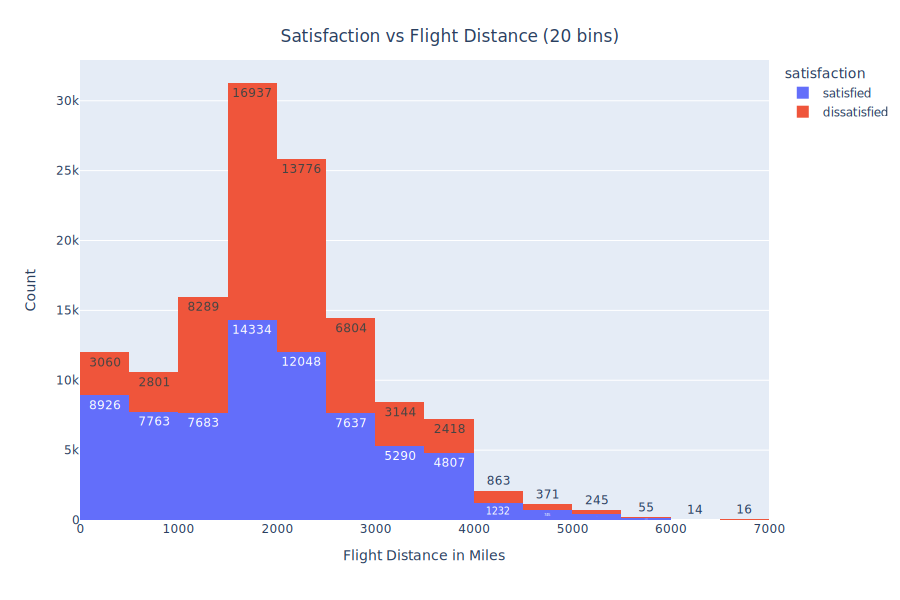

In [183]:
fig = px.histogram(df, x='Flight Distance', color='satisfaction', nbins=20, text_auto='.0f')
fig.update_layout(title='Satisfaction vs Flight Distance (20 bins)',
                  height=600, width=900,
                  title_x=0.5, title_y=0.95,
                  yaxis_title='Count',
                  xaxis_title='Flight Distance in Miles')
fig.show()

We'll focus on Flight distance < 4000 miles, where most of the data is present

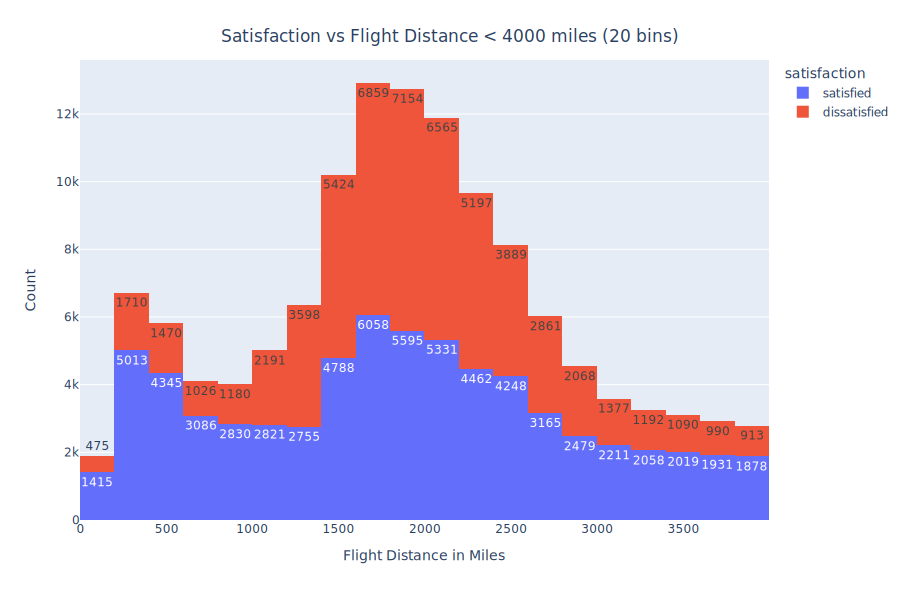

In [189]:
fd_under_4000_df = df[(df['Flight Distance']<4000)]
fig = px.histogram(fd_under_4000_df, x='Flight Distance', color='satisfaction', nbins=20, text_auto='.0f')
fig.update_layout(title='Satisfaction vs Flight Distance < 4000 miles (20 bins)',
                  height=600, width=900,
                  title_x=0.5, title_y=0.95,
                  yaxis_title='Count',
                  xaxis_title='Flight Distance in Miles')
fig.show()

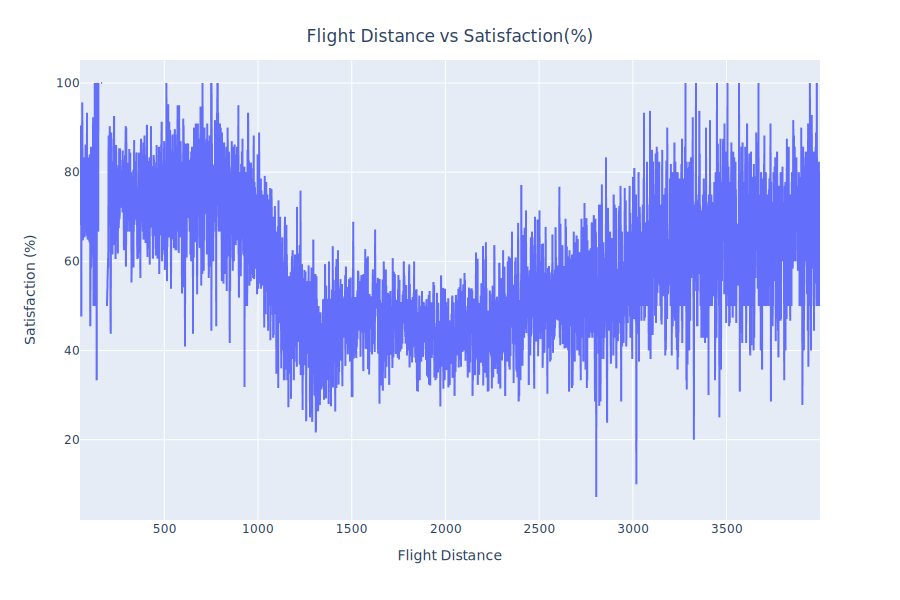

In [190]:
fd_grouped = fd_under_4000_df.groupby('Flight Distance')['satisfaction'].value_counts(normalize=True).unstack()
fd_satisfied = fd_grouped['satisfied'] * 100
fig = px.line(x=fd_satisfied.index, y=fd_satisfied.values, labels={'x': 'Flight Distance', 'y': 'Satisfaction (%)'})
fig.update_layout(title='Flight Distance vs Satisfaction(%)', title_x=0.5, title_y=0.95, height=600, width=900).show()

Air passengers eho fly mid-range flights (1000-2500 miles) showed more disatisfaction, compared to short (<1000 miles) or long (>3000 miles) flights satisfaction and the overall satisfaction rate (55%)

Customers totals per Flights Disatnce:
flew_leass_than_1000 : 17.379%
flew_1000_to_3000 : 67.359%
flew_gt_than_1000 : 15.262%


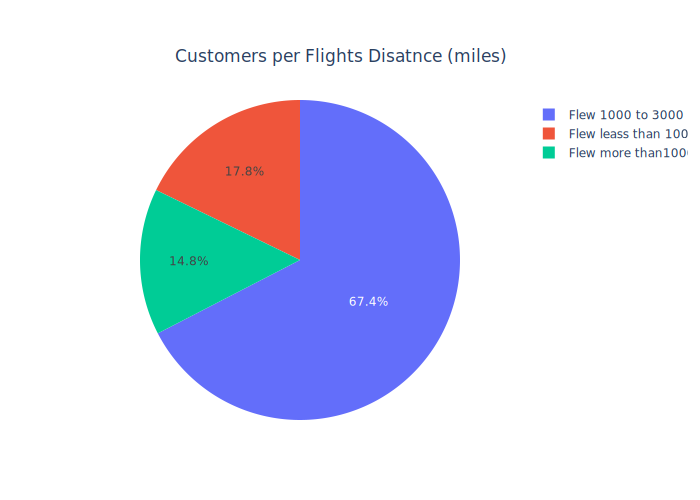

In [191]:
print(f'Customers totals per Flights Disatnce:')
print(f'flew_leass_than_1000 : {(len(df[df['Flight Distance'] <=1000]) / len(df)*100):.3f}%')
print(f'flew_1000_to_3000 : {(len(df[(df['Flight Distance'] > 1000) & (df['Flight Distance'] < 3000)]) / len(df) *100):.3f}%')
print(f'flew_gt_than_1000 : {(len(df[df['Flight Distance'] >=3000]) / len(df)*100):.3f}%')

labels = ['Flew leass than 1000','Flew 1000 to 3000','Flew more than1000']
values = [17.80, 67.42, 14.78]

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title='Customers per Flights Disatnce (miles)', title_x=0.25, title_y=0.9)
fig.show()

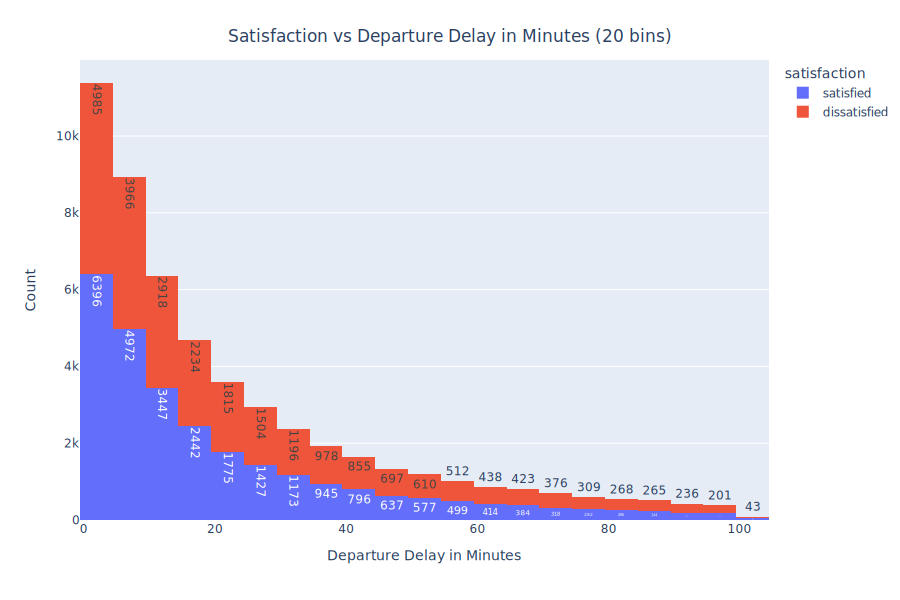

In [186]:
fig = px.histogram(df[(df['Departure Delay in Minutes']<=100) & (df['Departure Delay in Minutes']>0)], x='Departure Delay in Minutes', color='satisfaction', nbins=20, text_auto='.0f')
fig.update_layout(title='Satisfaction vs Departure Delay in Minutes (20 bins)',
                  height=600, width=900,
                  title_x=0.5, title_y=0.95,
                  yaxis_title='Count',
                  xaxis_title='Departure Delay in Minutes')
fig.show()

Departure delays of more than 15 minutes led to higher dissatisfaction rate, compared to short delays

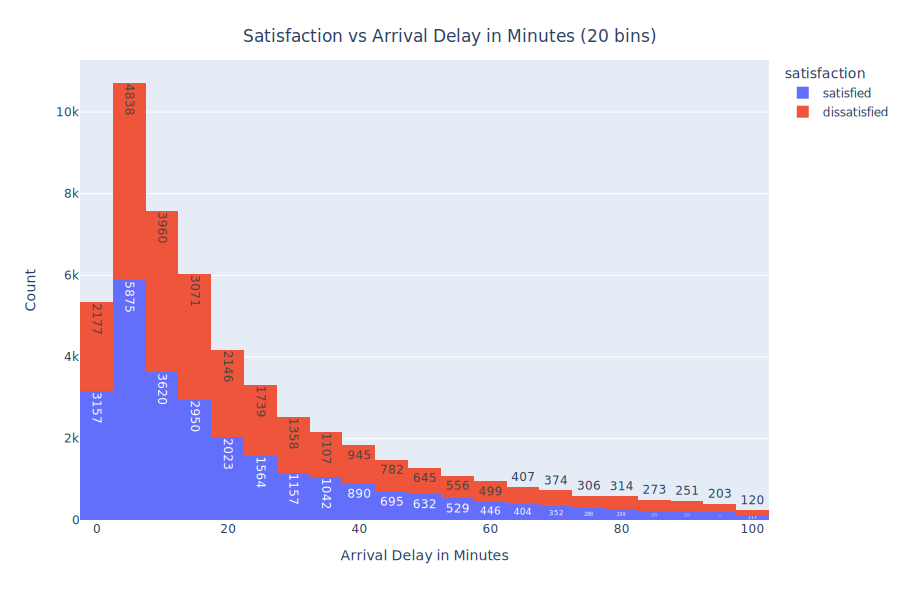

In [187]:
fig = px.histogram(df[(df['Arrival Delay in Minutes']<=100) & (df['Arrival Delay in Minutes']>0)], x='Arrival Delay in Minutes', color='satisfaction', nbins=20, text_auto='.0f')
fig.update_layout(title='Satisfaction vs Arrival Delay in Minutes (20 bins)',
                  height=600, width=900,
                  title_x=0.5, title_y=0.95,
                  yaxis_title='Count',
                  xaxis_title='Arrival Delay in Minutes')
fig.show()

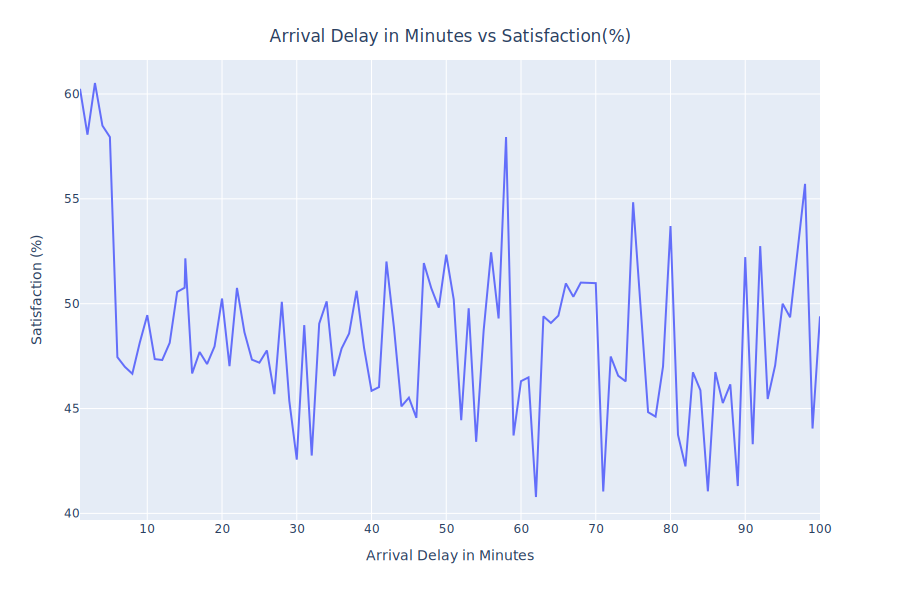

In [192]:
df_arrival_delay = df[(df['Arrival Delay in Minutes']<=100) & (df['Arrival Delay in Minutes']>0)]
arrival_delay_grouped = df_arrival_delay.groupby('Arrival Delay in Minutes')['satisfaction'].value_counts(normalize=True).unstack()
ad_satisfied = arrival_delay_grouped['satisfied'] * 100
fig = px.line(x=ad_satisfied.index, y=ad_satisfied.values, labels={'x': 'Arrival Delay in Minutes', 'y': 'Satisfaction (%)'})
fig.update_layout(title='Arrival Delay in Minutes vs Satisfaction(%)', title_x=0.5, title_y=0.95, height=600, width=900).show()

Arrival delays of more than 10 minutes led to higher dissatisfaction rate, compared to short delays 

#### Numerical Outliers Analysis

When looking into histograms of Arrival and Departure delays, we noticed that the data was skewed to the left with some outliers to the right. We'll look into the outliers data

In [193]:
# We'll look at the data distribution of Arrival and Departure Delays
columns =  ['Arrival Delay in Minutes', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Departure Delay in Minutes']
titles =  ['Arrival Delay in Minutes Histogram', 'Departure Delay in Minutes Histogram', 'Arrival Delay in Minutes BoxPlot', 'Departure Delay in Minutes BoxPlot']
dimensions = 2
fig = make_subplots(cols = 2, rows = 2, subplot_titles=titles)

dimension = 2

for i, column in enumerate(columns):
    row = math.floor((i + dimension) / dimensions)
    col = ((i + dimension) % dimension) + 1
    df_temp = df[df[column] > 0]
    if (row == 1) :
      fig.add_histogram(x = df_temp[column], row = row, col = col, showlegend=False)
      fig['layout'][f'yaxis{i+1}']['title'] = 'Count'
    else:
      fig.add_box(x = df_temp[column], row = row, col = col, showlegend=False)
      fig['layout'][f'yaxis{i+1}']['title'] = None

    fig['layout'][f'xaxis{i+1}']['title'] = 'Minutes'
    fig['layout'][f'yaxis{i+1}']['title']['standoff'] = 0
    fig['layout'][f'xaxis{i+1}']['title']['standoff'] = 0


fig.update_layout(height=600, width=900, title_text="Arrival and Departure Delay in Minutes Histograms and BoxPlots",  title_x=0.5, title_y=0.95)
fig.show()

Seems like we have some outliers at `Arrival Delay in Minutes` and `Departure Delay in Minutes` - lets remove them

In [197]:
# We'll remove the outliers for `Departure Delay in Minutes` and `Arrival Delay in Minutes`
from scipy.stats import zscore
features_with_outliers = ['Departure Delay in Minutes', 'Arrival Delay in Minutes']
outliers_list = []

for f in features_with_outliers:
    z_score = zscore(df[f])

    # removing outlier that are more than 3 standard deviations away from the mean
    threshold = 3

    outliers = df[abs(z_score) > threshold]
    outliers_list.extend(outliers.index)
    print(f'Number of outliers found for feature {f}: {len(outliers)}')

# dropping outliers
df_len_before = len(df)
print(f'df size before removing outliers: {df_len_before}')
df = df.drop(index=outliers_list).reset_index(drop=True)
print(f'df size after removing outliers: {len(df)}.\nTotal number of records removed: {df_len_before - len(df)} ')

Number of outliers found for feature Departure Delay in Minutes: 3913
Number of outliers found for feature Arrival Delay in Minutes: 3907
df size before removing outliers: 126807
df size after removing outliers: 122039.
Total number of records removed: 4768 


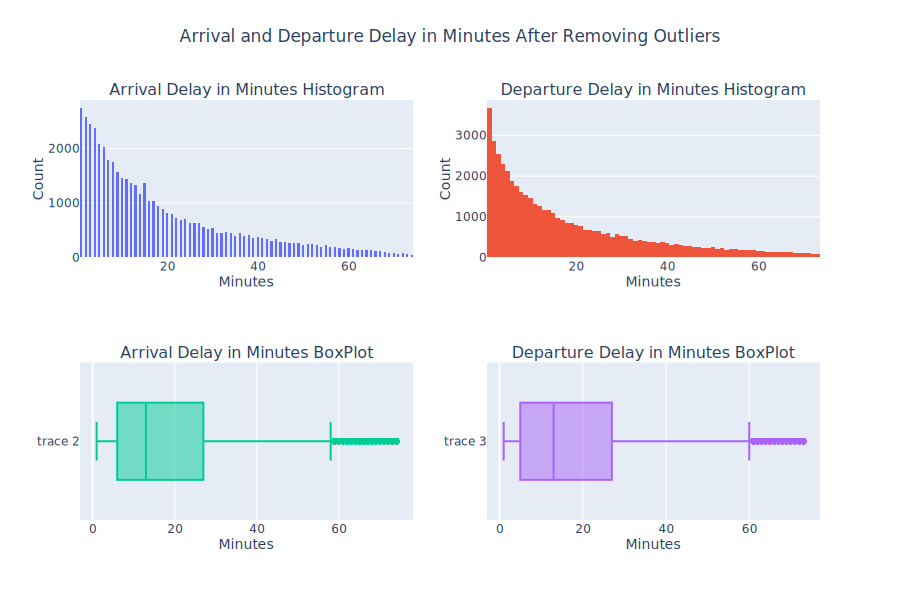

In [198]:
# We'll present the distribution of the 2 features after removing the outliers
columns =  ['Arrival Delay in Minutes', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Departure Delay in Minutes']
titles =  ['Arrival Delay in Minutes Histogram', 'Departure Delay in Minutes Histogram', 'Arrival Delay in Minutes BoxPlot', 'Departure Delay in Minutes BoxPlot']
dimensions = 2
fig = make_subplots(cols = 2, rows = 2, subplot_titles=titles)

dimension = 2

for i, column in enumerate(columns):
    row = math.floor((i + dimension) / dimensions)
    col = ((i + dimension) % dimension) + 1
    df_temp = df[df[column] > 0]
    if (row == 1) :
      fig.add_histogram(x = df_temp[column], row = row, col = col, showlegend=False)
      fig['layout'][f'yaxis{i+1}']['title'] = 'Count'
    else:
      fig.add_box(x = df_temp[column], row = row, col = col, showlegend=False)
      fig['layout'][f'yaxis{i+1}']['title'] = ''

    fig['layout'][f'xaxis{i+1}']['title'] = 'Minutes'
    fig['layout'][f'yaxis{i+1}']['title']['standoff'] = 0
    fig['layout'][f'xaxis{i+1}']['title']['standoff'] = 0


fig.update_layout(height=600, width=900, title_text="Arrival and Departure Delay in Minutes After Removing Outliers",  title_x=0.5, title_y=0.95)
fig.show()


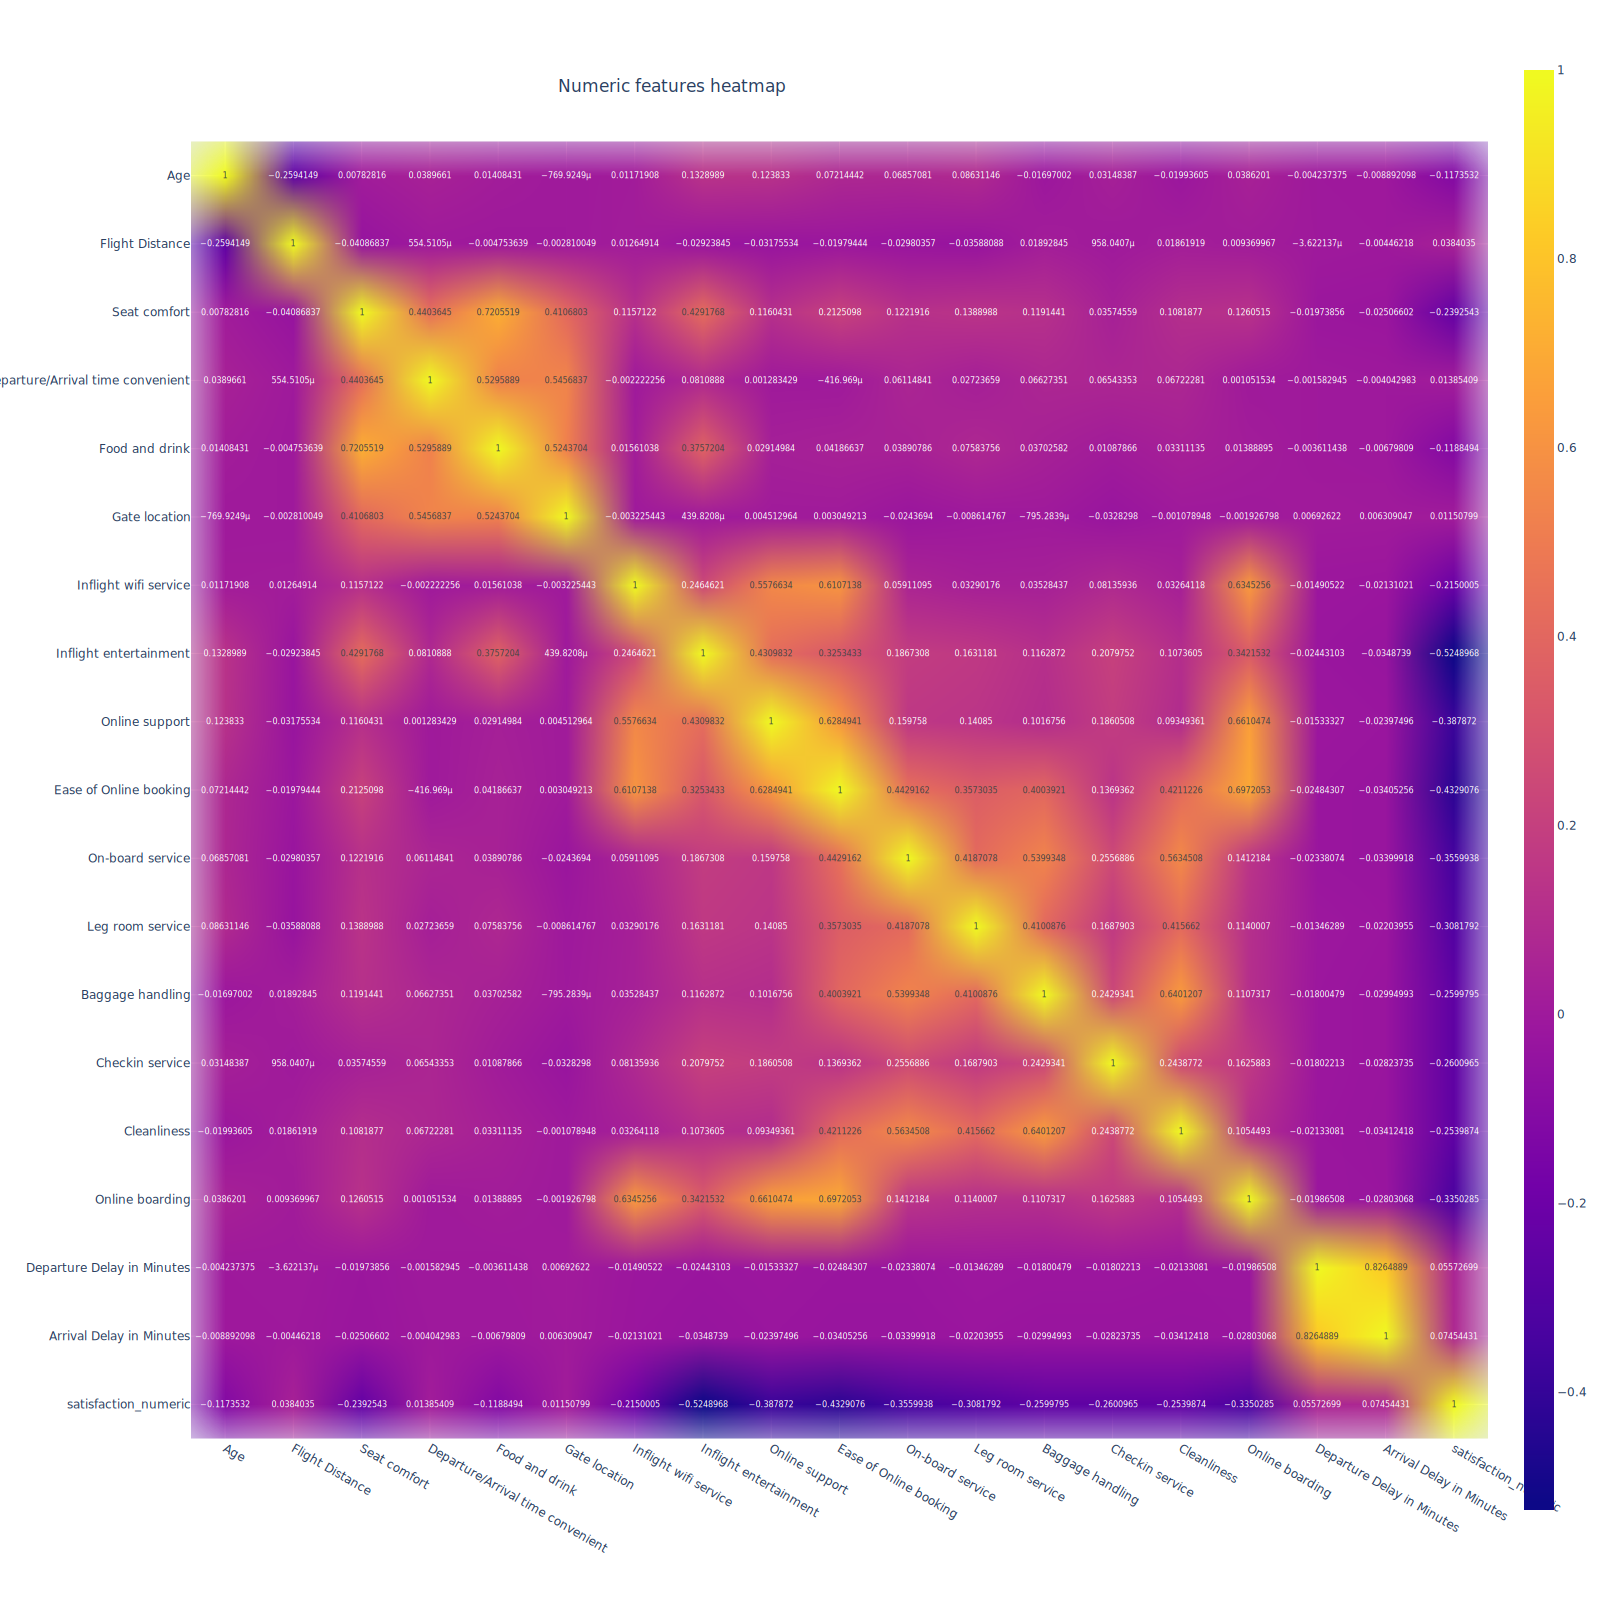

In [199]:
# encoding categorical target column to numeric for creating a heat map
df['satisfaction_numeric'] = df['satisfaction'].map({'satisfied': 0, 'dissatisfied': 1})

# building a heatmap for numeric features
df_numeric = df.select_dtypes(include=np.number)
fig = px.imshow(df_numeric.corr(), text_auto=True)
fig.update_layout(title='Numeric features heatmap',
                  title_x=0.42, title_y=0.95,
                  width=1600, height=1600).show()
fig.write_image("img/corr_matrix.png")

df = df.drop(['satisfaction_numeric'], axis=1)

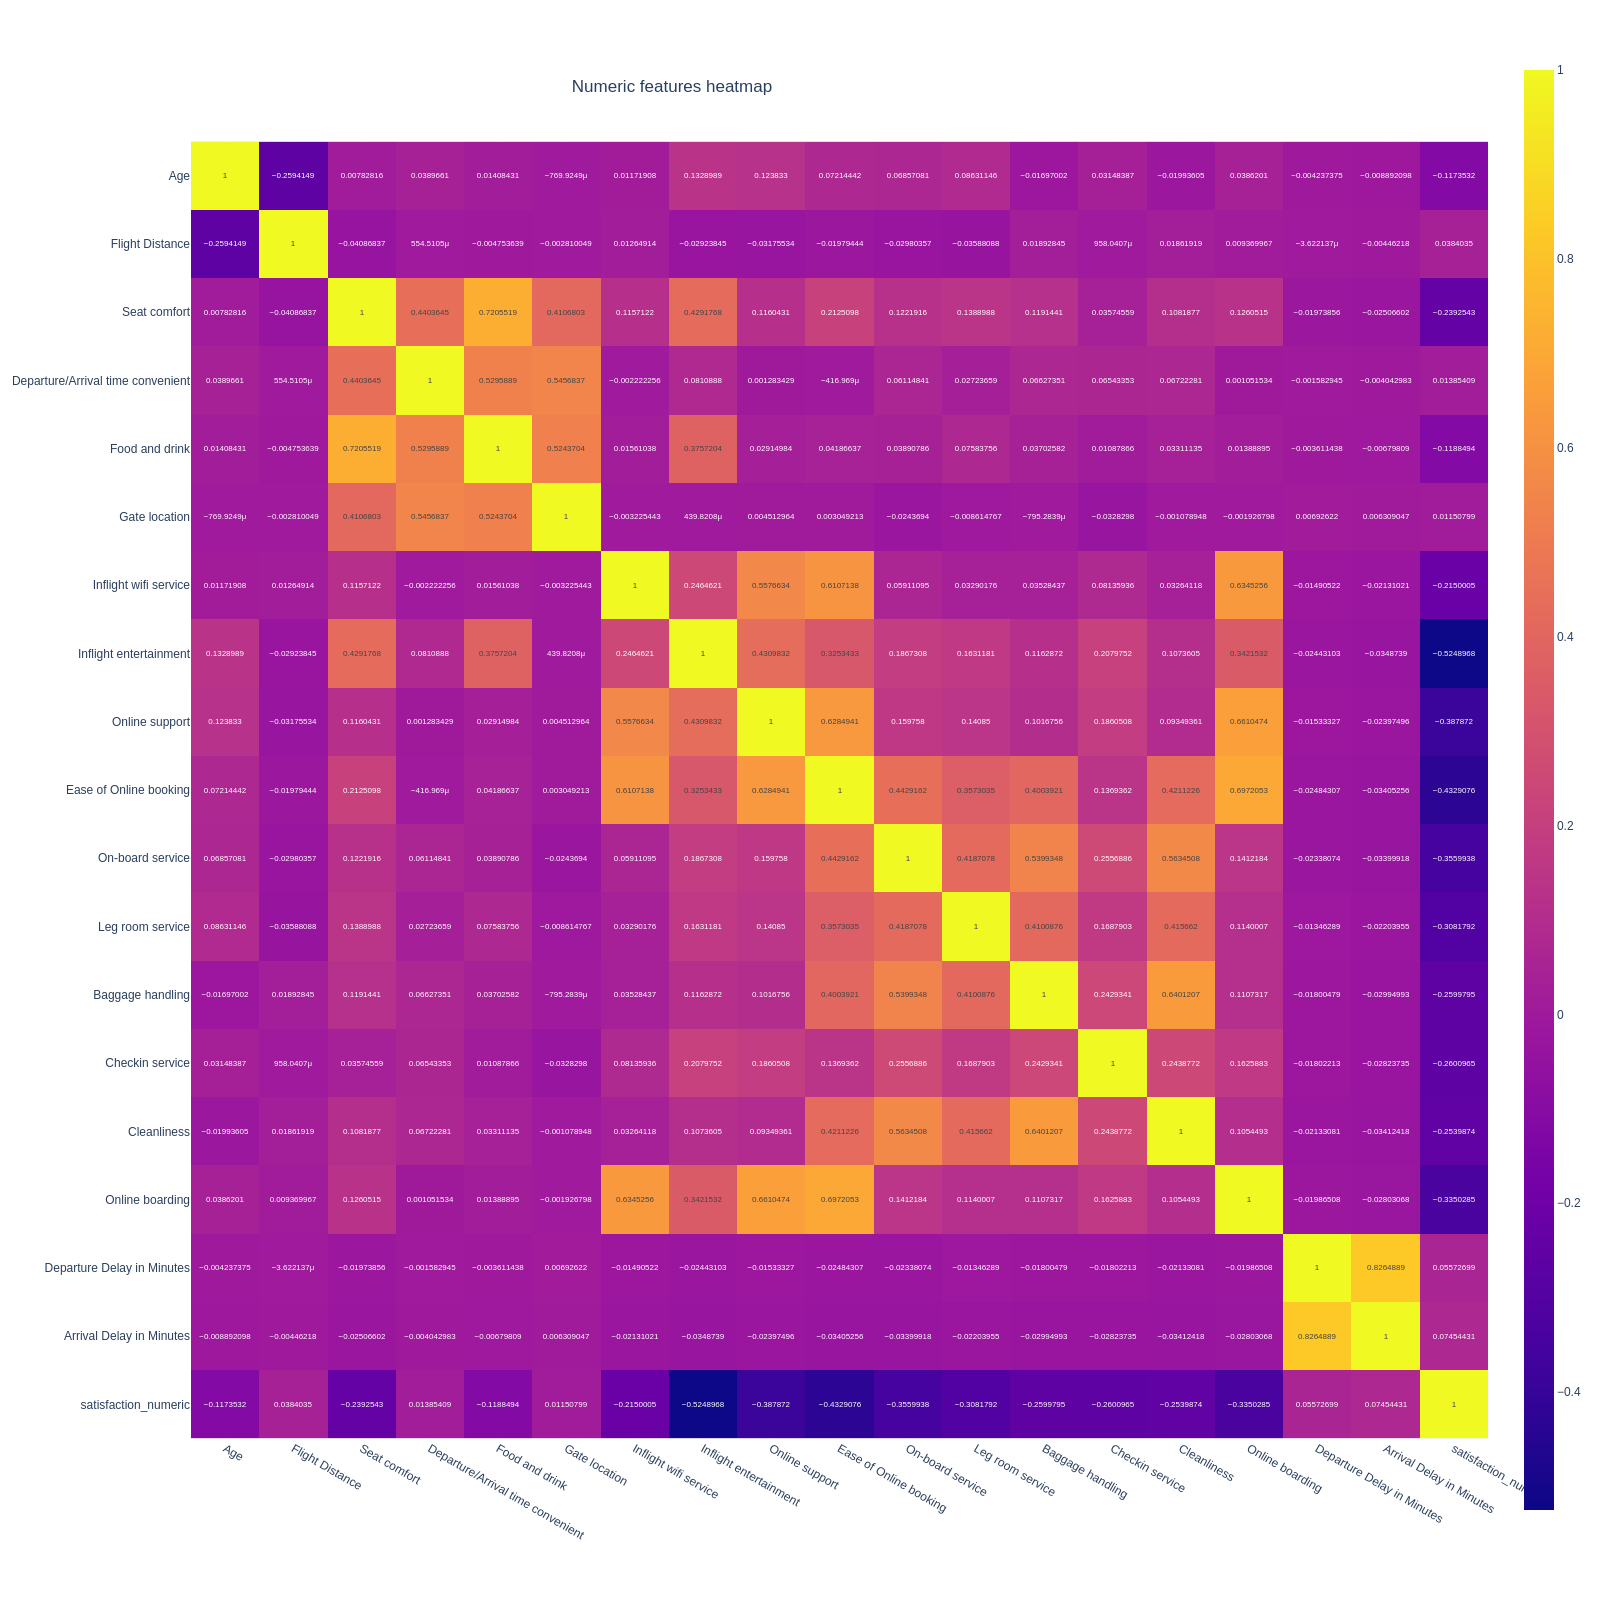

In [200]:
Image(filename='img/corr_matrix.png', width=1500, height=1500)

Theres a very high correlation (`90%`) between `Arrival Delay in Minutes` to `Departure Delay in Minutes`, which makes a lot of sense since both are in practical almost the same metrics. Also, we found high correlation between survey results on `Inflight WiFi Service` and `Online Boarding`(`63%`), `Easy of Online Boarding` and `Online Boarding` (`69.7%`), `Online Support` and `Online Boarding` (`66%`) and - maybe surprisingly - `Food and Drink` and `Seat Comfort` (`71.7%`)

I think that the similarity in the survey results might show that we might be able to shorten the surveys in the future.

### Categorical features and Customer Survey features

#### Customer Survey Features

In [201]:
# Get a list of customer survey columns
survey_columns = df.iloc[:, 6:20].columns.tolist()
print(survey_columns)

['Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']


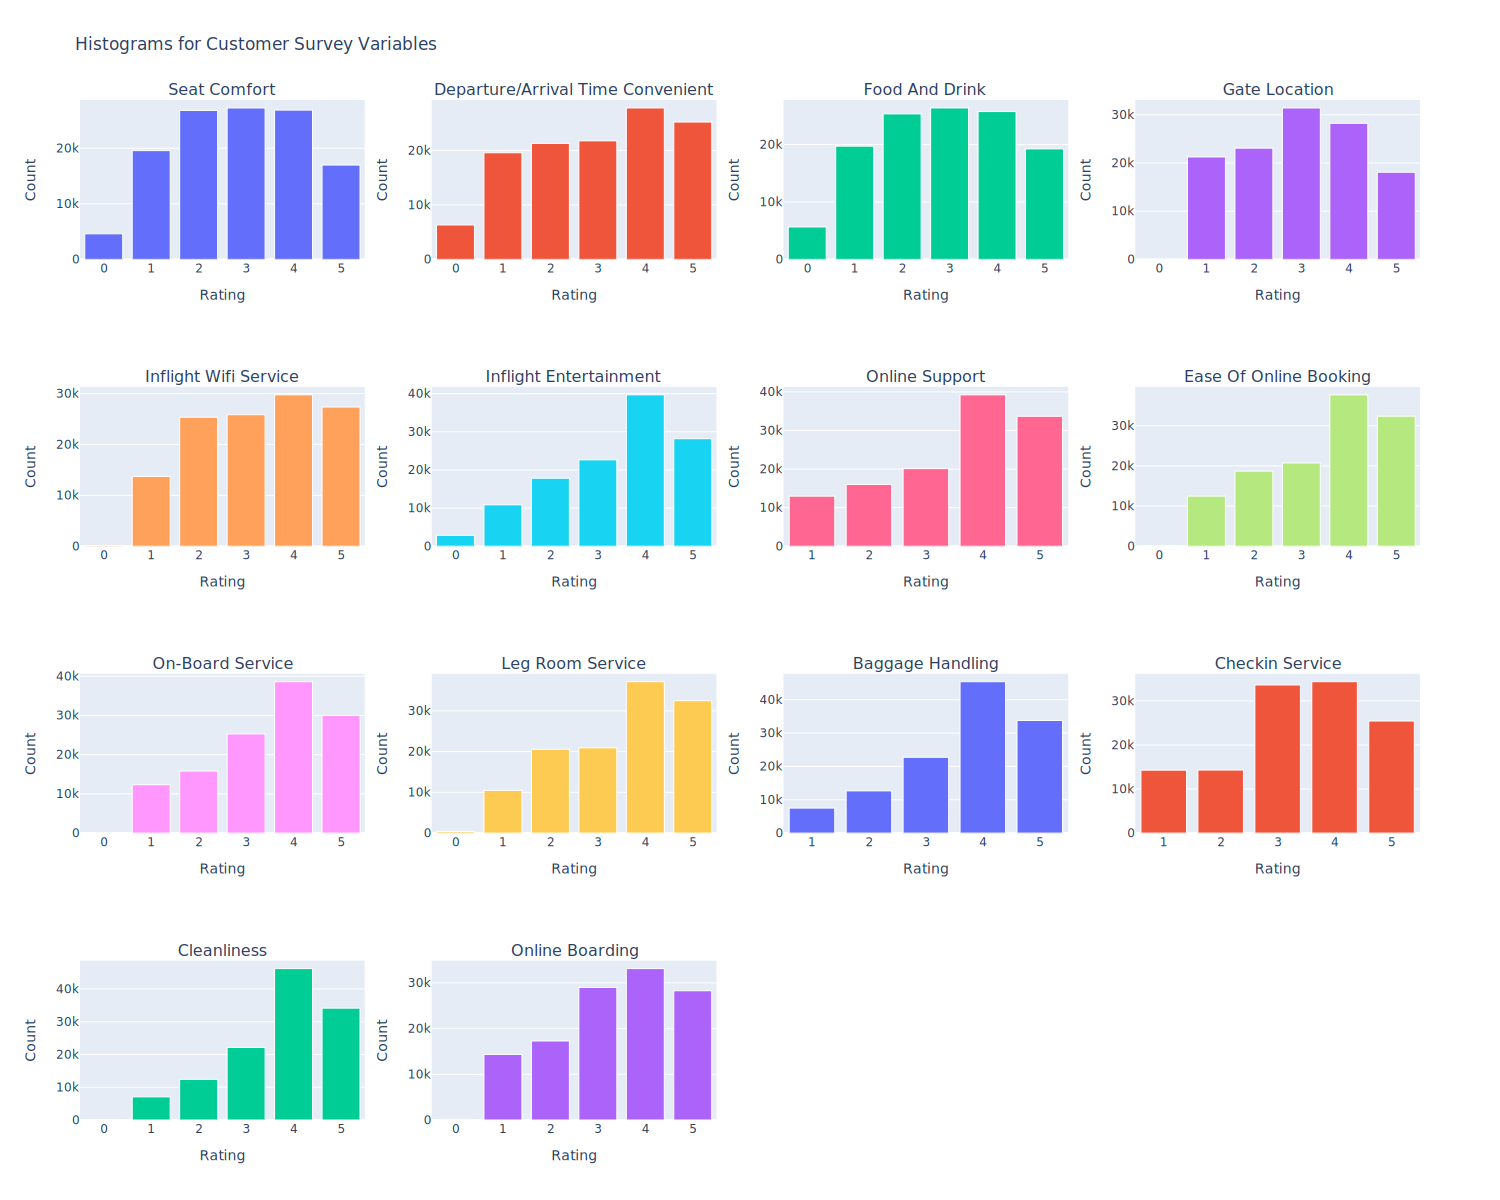

In [202]:
columns = survey_columns

dimension = math.ceil(np.sqrt(len(columns)))
fig = make_subplots(cols = dimension, rows = dimension, subplot_titles=(list(map(lambda x: x.replace('_', " ").title(), columns))))

for i, column in enumerate(columns):
    row = math.floor((i + dimension) / dimension)
    col = ((i + dimension) % dimension) + 1
    fig.add_histogram(x = df[column], row = row, col = col, showlegend=False)

    fig['layout'][f'xaxis{i+1}']['title'] = 'Rating'
    fig['layout'][f'yaxis{i+1}']['title'] = 'Count'

    fig.update_traces(marker_line_width=1,marker_line_color="white")
    if column in survey_columns:
      fig.update_xaxes(categoryorder='array', categoryarray= [0, 1, 2, 3, 4, 5])

fig.update_layout(height=1200, width=1500, title_text="Histograms for Customer Survey Variables")
fig.update_xaxes(type='category')
fig.show()

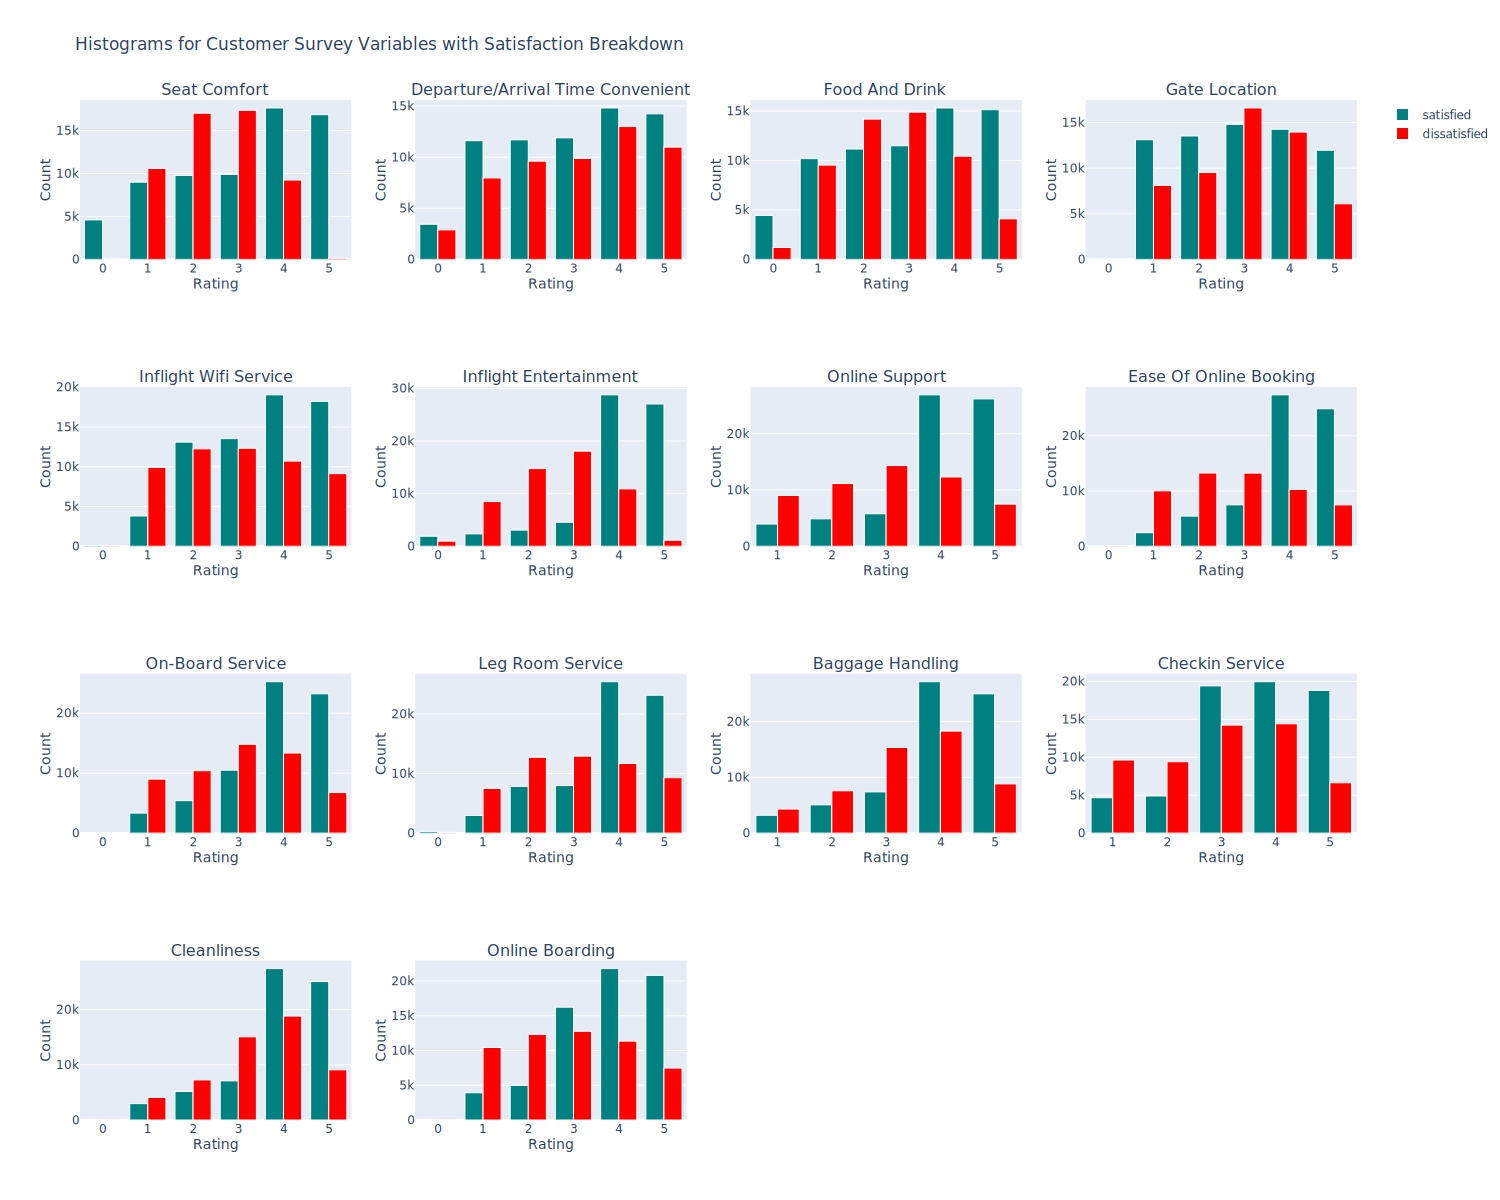

In [203]:
columns = survey_columns

dimension = math.ceil(np.sqrt(len(columns)))
fig = make_subplots(cols = dimension, rows = dimension, subplot_titles=(list(map(lambda x: x.replace('_', " ").title(), columns))))

df_satisfied = df[df['satisfaction'] == 'satisfied']
df_dissatisfied = df[df['satisfaction'] == 'dissatisfied']

for i, column in enumerate(columns):
    row = math.floor((i + dimension) / dimension)
    col = ((i + dimension) % dimension) + 1
    fig.add_histogram(x = df_satisfied[column], row = row, col = col, name='satisfied', marker_color='teal', showlegend=(i==0))
    fig.add_histogram(x = df_dissatisfied[column], row = row, col = col, name='dissatisfied', marker_color='red', showlegend=(i==0))
    fig['layout'][f'yaxis{i+1}']['title'] = 'Count'
    fig['layout'][f'xaxis{i+1}']['title'] = 'Rating'
    fig['layout'][f'yaxis{i+1}']['title']['standoff'] = 0
    fig['layout'][f'xaxis{i+1}']['title']['standoff'] = 0
    fig.update_traces(marker_line_width=1,marker_line_color="white")
    fig.update_xaxes(categoryorder='array', categoryarray= [0, 1, 2, 3, 4, 5])

fig.update_layout(height=1200, width=1500, title_text="Histograms for Customer Survey Variables with Satisfaction Breakdown")
fig.update_xaxes(type='category')
fig.show()

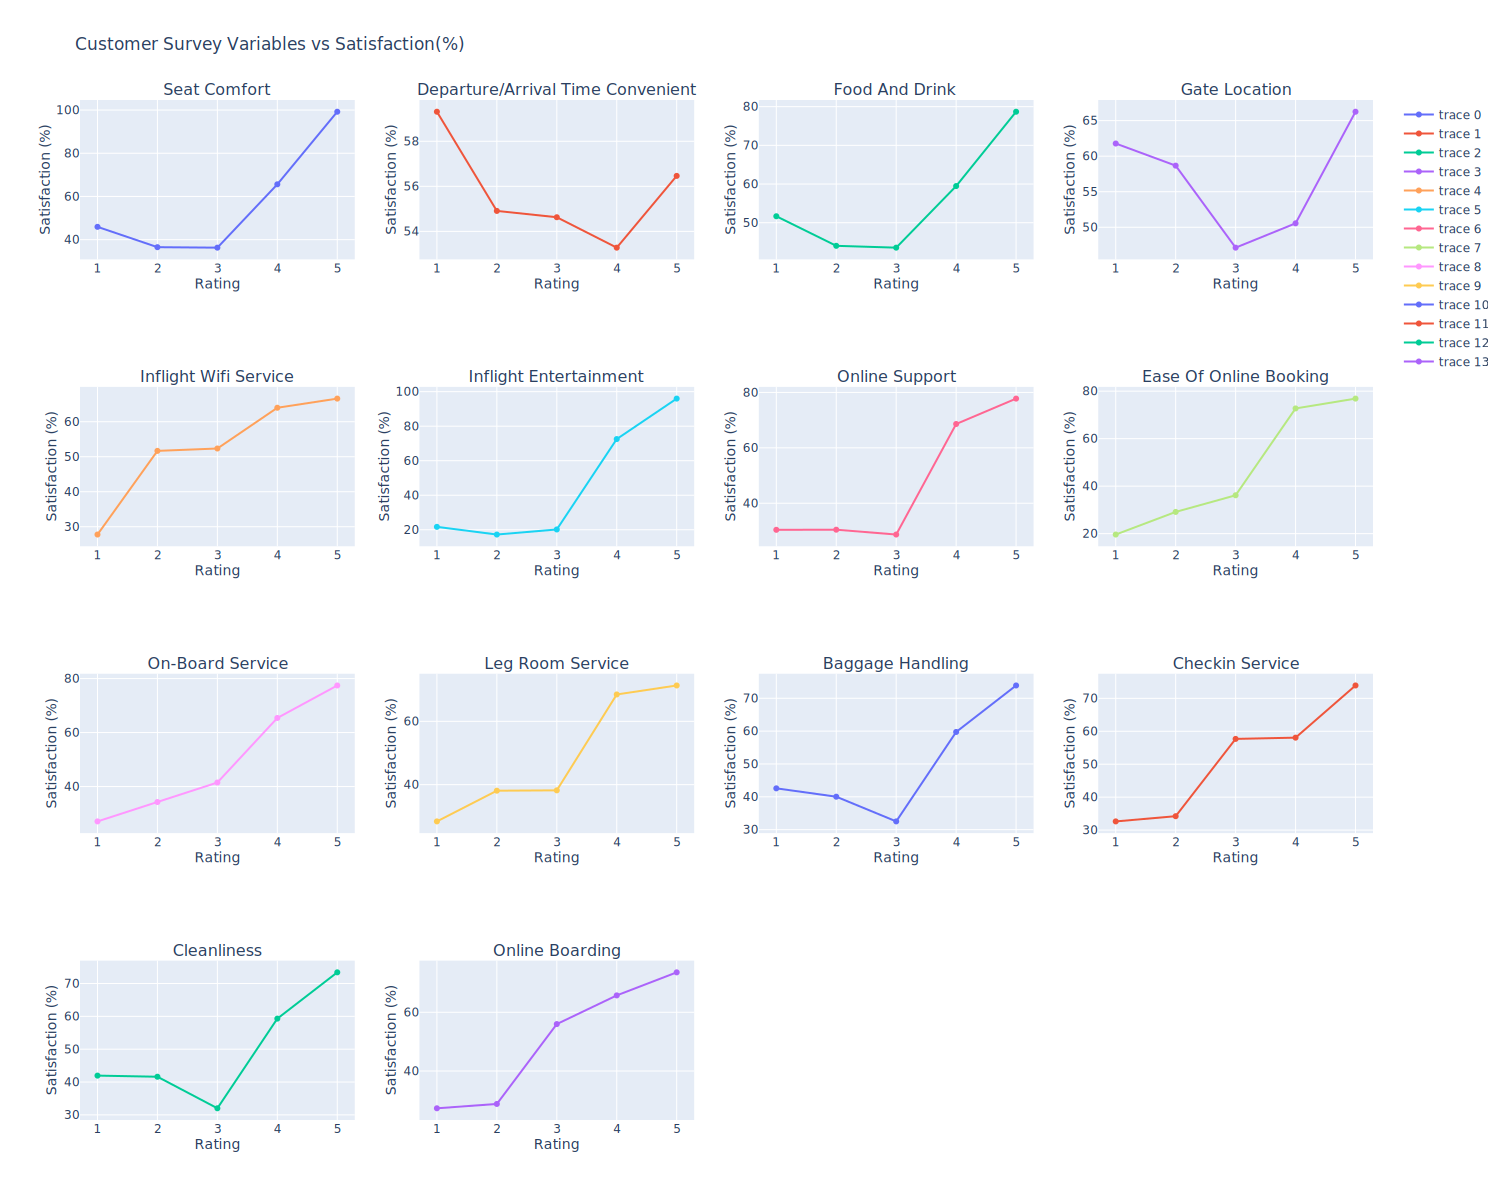

In [204]:
columns = survey_columns

dimension = math.ceil(np.sqrt(len(columns)))
fig = make_subplots(cols = dimension, rows = dimension, subplot_titles=(list(map(lambda x: x.replace('_', " ").title(), columns))))

df_satisfied = df[df['satisfaction'] == 'satisfied']
df_dissatisfied = df[df['satisfaction'] == 'dissatisfied']

for i, column in enumerate(columns):
  row = math.floor((i + dimension) / dimension)
  col = ((i + dimension) % dimension) + 1
  grouped = df.groupby(column)['satisfaction'].value_counts(normalize=True).unstack()
  mask = grouped.index != 0
  grouped = grouped[mask]
  grouped_satisfied = grouped['satisfied'] * 100
  fig.add_trace(go.Scatter(x=grouped_satisfied.index, y=grouped_satisfied.values),row = row, col = col)
  fig.update_layout(title=f'{column} vs Satisfaction(%)', title_x=0.5, title_y=0.95, height=600, width=900)
  fig['layout'][f'yaxis{i+1}']['title'] = 'Satisfaction (%)'
  fig['layout'][f'xaxis{i+1}']['title'] = 'Rating'
  fig['layout'][f'yaxis{i+1}']['title']['standoff'] = 0
  fig['layout'][f'xaxis{i+1}']['title']['standoff'] = 0
  fig.update_xaxes(categoryorder='array', categoryarray= [0, 1, 2, 3, 4, 5])

fig.update_layout(height=1200, width=1500, title=f'Customer Survey Variables vs Satisfaction(%)')
fig.show()

#### Analyzing  Customer Survey Variables for Disloyal Customers

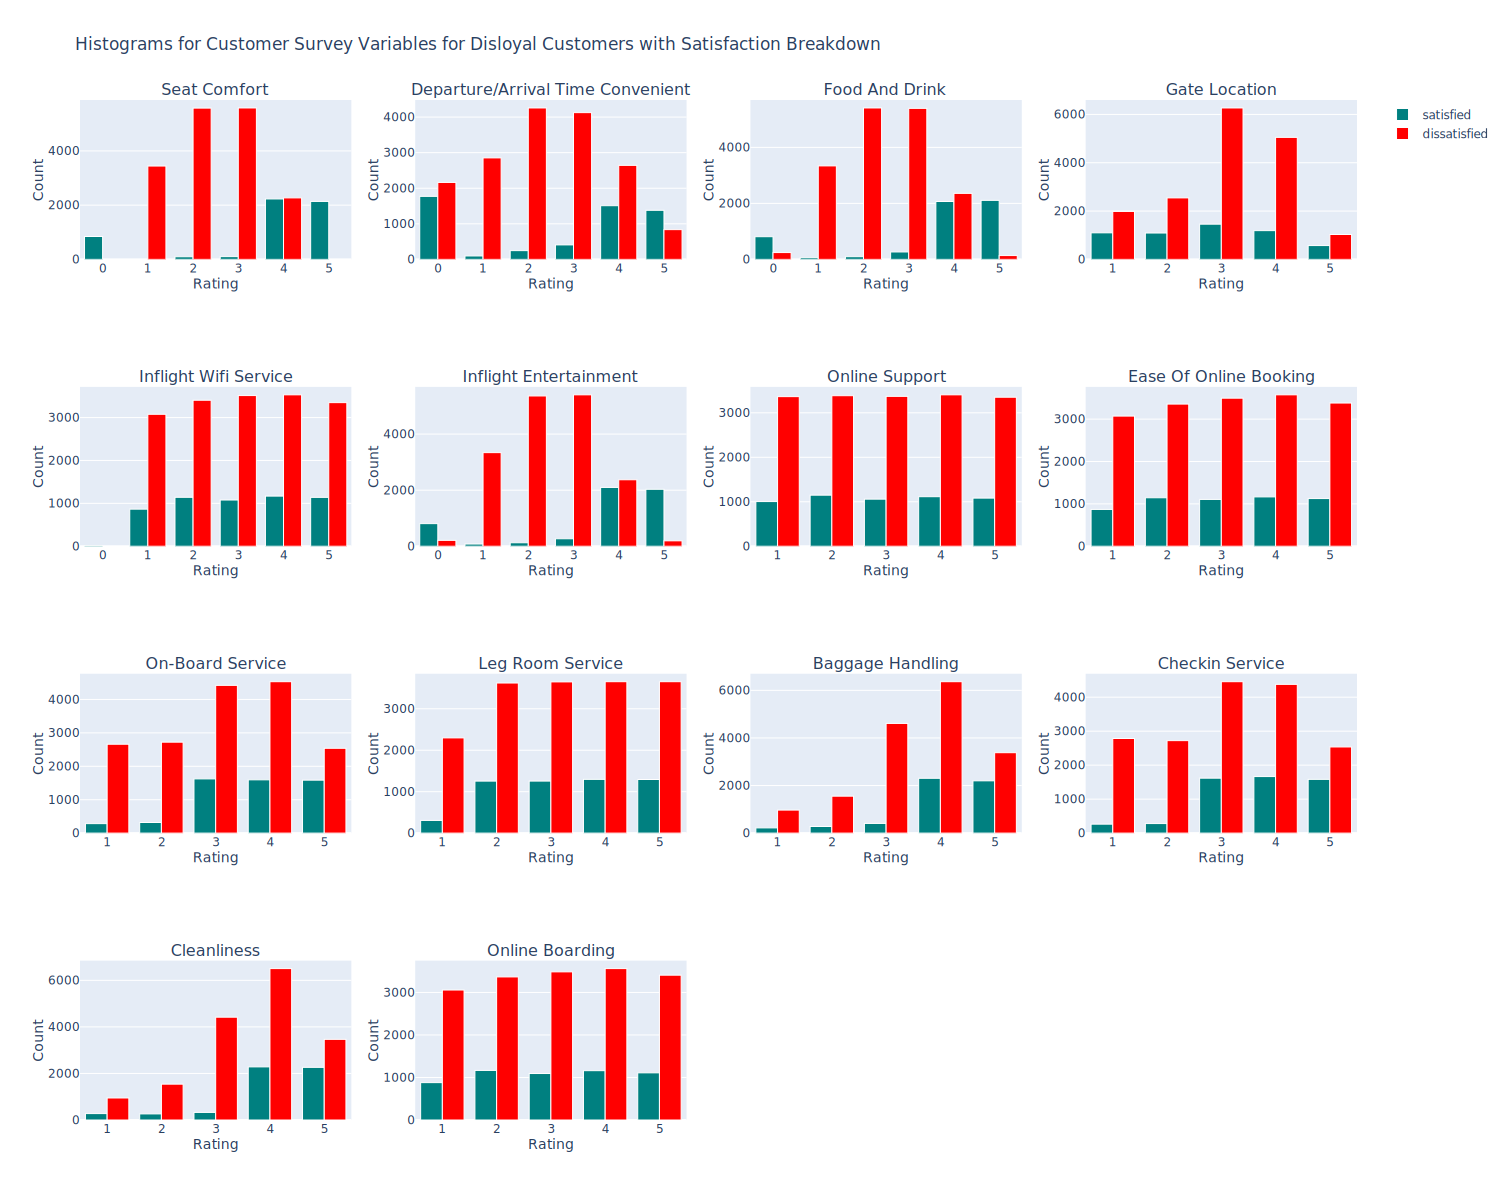

In [205]:
columns = survey_columns

df_disloyal = df[df['Customer Type'] == 'disloyal Customer']

dimension = math.ceil(np.sqrt(len(columns)))
fig = make_subplots(cols = dimension, rows = dimension, subplot_titles=(list(map(lambda x: x.replace('_', " ").title(), columns))))

df_satisfied = df_disloyal[df_disloyal['satisfaction'] == 'satisfied']
df_dissatisfied = df_disloyal[df_disloyal['satisfaction'] == 'dissatisfied']

for i, column in enumerate(columns):
    row = math.floor((i + dimension) / dimension)
    col = ((i + dimension) % dimension) + 1
    fig.add_histogram(x = df_satisfied[column], row = row, col = col, name='satisfied', marker_color='teal', showlegend=(i==0))
    fig.add_histogram(x = df_dissatisfied[column], row = row, col = col, name='dissatisfied', marker_color='red', showlegend=(i==0))
    fig['layout'][f'yaxis{i+1}']['title'] = 'Count'
    fig['layout'][f'xaxis{i+1}']['title'] = 'Rating'
    fig['layout'][f'yaxis{i+1}']['title']['standoff'] = 0
    fig['layout'][f'xaxis{i+1}']['title']['standoff'] = 0
    fig.update_traces(marker_line_width=1,marker_line_color="white")
    fig.update_xaxes(categoryorder='array', categoryarray= [0, 1, 2, 3, 4, 5])

fig.update_layout(height=1200, width=1500, title_text="Histograms for Customer Survey Variables for Disloyal Customers with Satisfaction Breakdown")
fig.update_xaxes(type='category')
fig.show()

##### Customer Survey Features Satisfaction Rates for Disloyal Customers

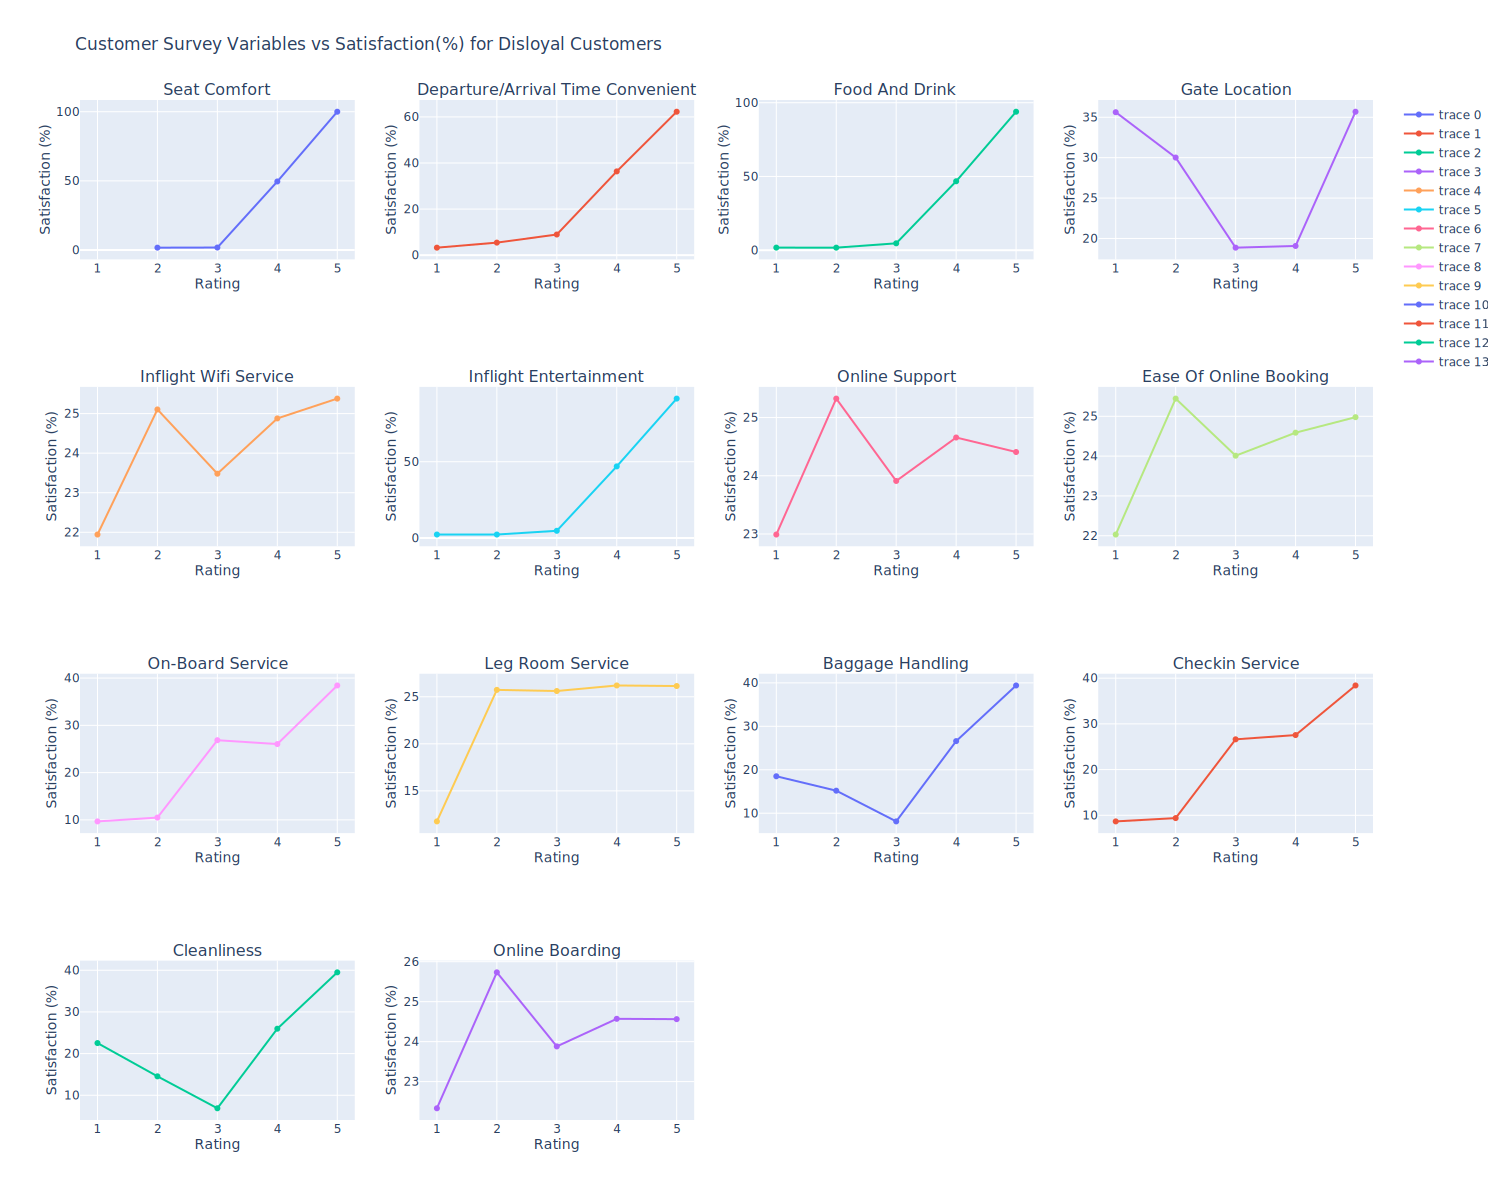

In [206]:
columns = survey_columns

dimension = math.ceil(np.sqrt(len(columns)))
fig = make_subplots(cols = dimension, rows = dimension, subplot_titles=(list(map(lambda x: x.replace('_', " ").title(), columns))))

for i, column in enumerate(columns):
  row = math.floor((i + dimension) / dimension)
  col = ((i + dimension) % dimension) + 1
  grouped = df_disloyal.groupby(column)['satisfaction'].value_counts(normalize=True).unstack()
  mask = grouped.index != 0
  grouped = grouped[mask]
  grouped_satisfied = grouped['satisfied'] * 100
  fig.add_trace(go.Scatter(x=grouped_satisfied.index, y=grouped_satisfied.values),row = row, col = col)
  fig.update_layout(title=f'{column} vs Satisfaction(%)', title_x=0.5, title_y=0.95, height=600, width=900)
  fig['layout'][f'yaxis{i+1}']['title'] = 'Satisfaction (%)'
  fig['layout'][f'xaxis{i+1}']['title'] = 'Rating'
  fig['layout'][f'yaxis{i+1}']['title']['standoff'] = 0
  fig['layout'][f'xaxis{i+1}']['title']['standoff'] = 0
  fig.update_xaxes(categoryorder='array', categoryarray= [0, 1, 2, 3, 4, 5])

fig.update_layout(height=1200, width=1500, title=f'Customer Survey Variables vs Satisfaction(%) for Disloyal Customers')
fig.show()

The following features seems to be the most contributing to the disloyal customers high dissatisfaction rate:
* Seat Comfort
* In-flight Entertainment
* Departure/Arrival Time Convinient
* Food And Drink
* On-Board Service
* Cleanliness
* Baggage Handling
* Checkin Service

### Categorical Features

First we'll look at pie charts of the different categorical variables to understand the distribution each category

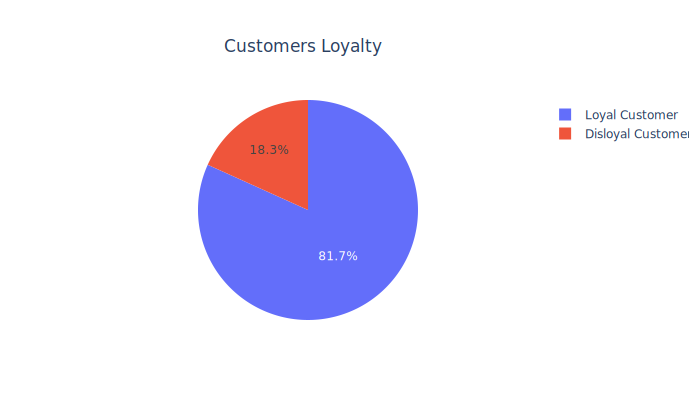

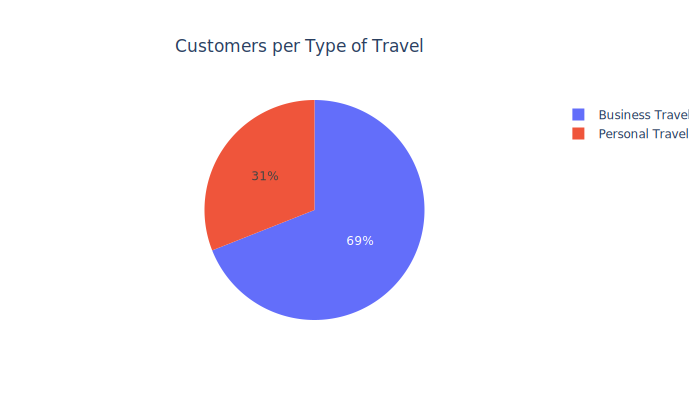

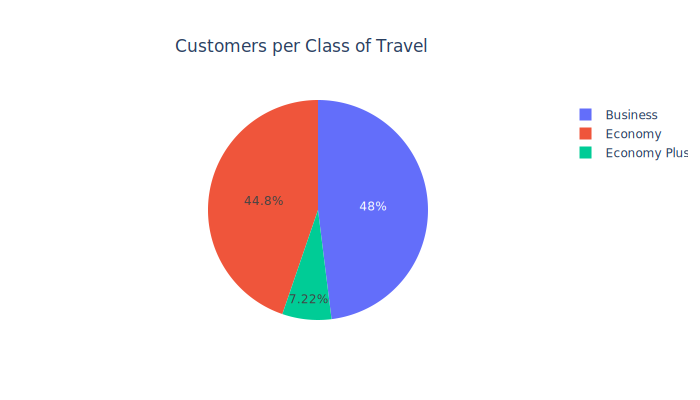

In [215]:
loyal =  len(df[df["Customer Type"] == "Loyal Customer"]) / len(df)
disloyal =  len(df[df["Customer Type"] == "disloyal Customer"]) / len(df)
labels = ['Loyal Customer', 'Disloyal Customer']
values = [loyal, disloyal]
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title='Customers Loyalty', title_x=0.32, title_y=0.9, height=400).show()

personal =  len(df[df["Type of Travel"] == "Personal Travel"]) / len(df)
business =  len(df[df["Type of Travel"] == "Business travel"]) / len(df)
labels = ['Personal Travel', 'Business Travel']
values = [personal, business]
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title='Customers per Type of Travel',   title_x=0.25, title_y=0.9, height=400).show()

eco =  len(df[df["Class"] == "Eco"]) / len(df)
eco_plus =  len(df[df["Class"] == "Eco Plus"]) / len(df)
business =  len(df[df["Class"] == "Business"]) / len(df)
labels = ['Economy', 'Economy Plus','Business']
values = [eco, eco_plus, business]
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title='Customers per Class of Travel', title_x=0.25, title_y=0.9, height=400).show()

We'll now look at categorical variables distribution with satisfaction breakdown

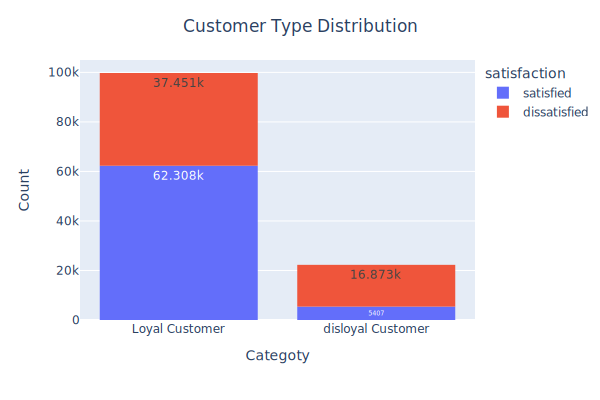

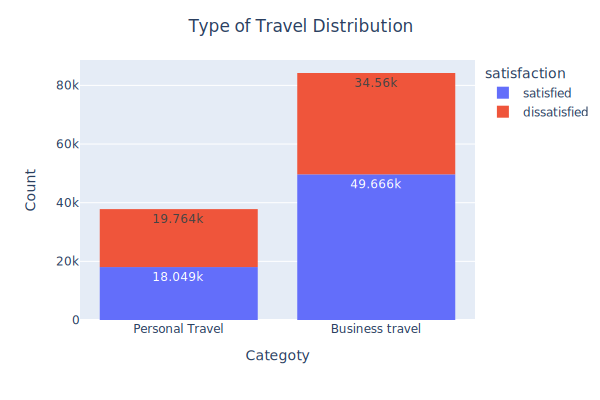

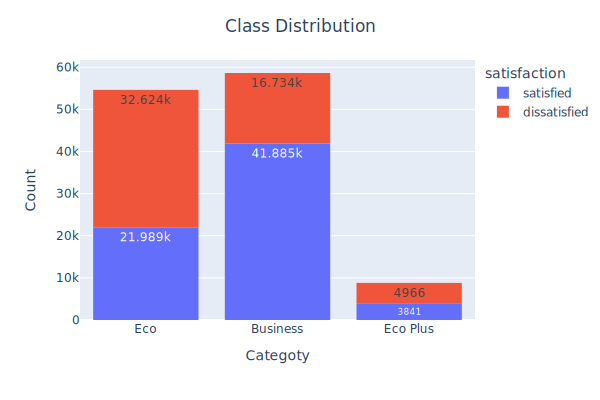

In [217]:
cat_columns = df.select_dtypes(include='object').columns.tolist()
cat_columns.remove('satisfaction')
for col in cat_columns:
    fig = px.histogram(df, x=col, color='satisfaction', text_auto=True)
    fig.update_layout(title=f'{col} Distribution',
                      title_x=0.5, title_y=0.95,
                      width=600, height=400,
                      yaxis_title='Count',
                      xaxis_title='Categoty')
    fig.show()

We can notice some characteristics of the data set from the above bar charts:
  * There are more than 4 times loyal customers in the dataset compared to disloyal customers
  * There are more than double customers on business travel vs personal travel
  * The data set is well balanced between customers who flew economy and business classes. Less than 10% of the customers flew economy plus

In [218]:
satisfied = df[df.satisfaction.isin(['satisfied'])]
dissatisfied = df[df.satisfaction.isin(['dissatisfied'])]
len(dissatisfied)

54324

In [219]:
# helper function to generate ratio satisfaction DataFrame
def get_satisfaction_rate_dataframe(mydf, category):
    df_all = mydf.groupby(category).agg('count')['satisfaction']
    df_category_satisfied = df[df.satisfaction.isin(['satisfied'])].groupby(category).agg('count')['satisfaction']
    df_category_dissatisfied = df[df.satisfaction.isin(['dissatisfied'])].groupby(category).agg('count')['satisfaction']
    category_satisfied_ratio = df_category_satisfied / df_all
    category_dissatisfied_ratio = 1 - category_satisfied_ratio
    categoty_satisfaction_frame = {'satisfied': category_satisfied_ratio,
         'dissatisfied': category_dissatisfied_ratio}
    cat_frame = pd.DataFrame(categoty_satisfaction_frame)
    return cat_frame

# calculates the satisfaction rate given a dataframe
def get_satisfaction_rate(df):
    return len(df[df.satisfaction.isin(['satisfied'])]) / len(df)

In [220]:
# lets test the `get_satisfaction_rate` function
base_satisfaction = round(get_satisfaction_rate(df), 3)
print(f'base satisfaction rate is: {base_satisfaction}')

base satisfaction rate is: 0.555


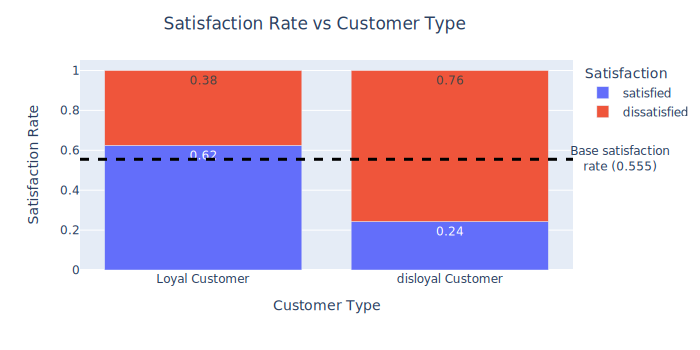

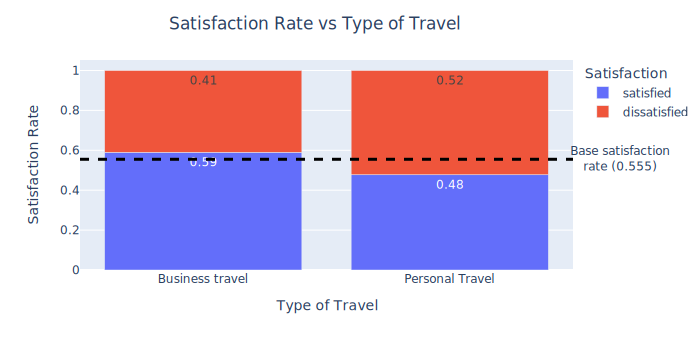

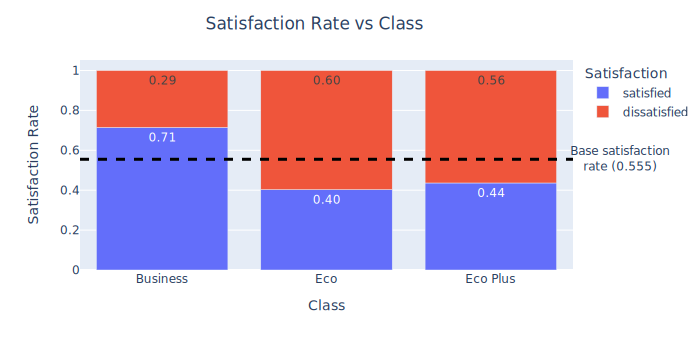

In [221]:
columns = ['Customer Type', 'Type of Travel', 'Class']
for column in columns:
  df_satisfied= get_satisfaction_rate_dataframe(df, column)

  fig = px.bar(df_satisfied, x=df_satisfied.index, text_auto='.2f', y=['satisfied',  'dissatisfied'], labels={'variable': 'Satisfaction'}).update_xaxes(type='category')
  fig.add_hline(y=base_satisfaction, line_width=3, line_dash="dash", line_color="black",  annotation_text=f"Base satisfaction<br>rate ({base_satisfaction})",
                              annotation_position="right")
  fig.update_layout(title=f'Satisfaction Rate vs {column}', title_x = 0.45, title_y = 0.95,
                width=700, height=350,
                yaxis_title = 'Satisfaction Rate',

                xaxis={'categoryorder':'sum ascending'},
                xaxis_title = column)
  fig.show()

* Customers who flew `Business Class`, showed higher satisfaction rate of `71%` vs the aggregated satisfaction rate of `55%`
* Customers who were on a `Personal Travel`, showed lower satisfaction rate of `48%` vs the aggregated satisfaction rate of `55%`
* `Disloyal Customers` showed a significant lower satisfaction rate of `24%` vs the aggregated satisfaction rate of `55%`

## Features Engineering

We'll encode categorical variables with `OneHotEncoder` to preserve ordinality of these features. Then, we'll scale the numerical features with `StandardScaler`. This is crtical for neural networks training later in the models section

df.head()

In [223]:
# Initialize OneHotEncoder
encoder = OneHotEncoder(drop='if_binary', sparse_output=False)
cat_columns = ['Customer Type', 'Class', 'Type of Travel']
# Fit and transform categorical columns
encoded_cat_cols = encoder.fit_transform(df[cat_columns])

# Convert to DataFrame
encoded_df = pd.DataFrame(encoded_cat_cols, columns=encoder.get_feature_names_out(cat_columns))

# Concatenate with numerical columns
num_cols = df.select_dtypes(include='number').columns.tolist()
encoded_df = pd.concat([encoded_df, df[num_cols]], axis=1)
encoded_df.head()

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform numerical columns
scaled_num_cols = scaler.fit_transform(encoded_df[num_cols])
encoded_df[num_cols] = scaled_num_cols

encoded_df['satisfaction'] = df['satisfaction'].map({'satisfied': 0, 'dissatisfied': 1})
df = encoded_df
df.head()

Customer Type_disloyal Customer  Class_Business  Class_Eco  Class_Eco Plus  \
0                              0.0             0.0        1.0             0.0   
1                              0.0             0.0        1.0             0.0   
2                              0.0             0.0        1.0             0.0   
3                              0.0             0.0        1.0             0.0   
4                              0.0             0.0        1.0             0.0   

   Type of Travel_Personal Travel       Age  Flight Distance  Seat comfort  \
0                             1.0  1.690301        -1.664944     -2.035872   
1                             1.0 -1.617863         0.177179     -2.035872   
2                             1.0  1.359484        -1.312846     -2.035872   
3                             1.0  2.021117        -1.577411     -2.035872   
4                             1.0 -0.625414        -0.062798     -2.035872   

   Departure/Arrival time convenient  Food and drink  ...  \
0                          -1.955827       -1.975567  ...   
1                          -1.955827       -1.975567  ...   
2                          -1.955827       -1.975567  ...   
3                          -1.955827       -1.975567  ...   
4                          -1.955827       -1.975567  ...   

   Ease of Online booking  On-board service  Leg room service  \
0               -0.368935         -0.375139         -2.691523   
1               -1.135373         -0.375139         -0.375059   
2               -1.901812         -1.952724         -2.691523   
3               -1.135373         -1.163931         -2.691523   
4               -1.135373          1.202447          0.397096   

   Baggage handling  Checkin service  Cleanliness  Online boarding  \
0         -0.603420         1.314723    -0.629352        -1.046616   
1          0.260361         0.519377     0.243606        -1.046616   
2         -2.330983         0.519377    -2.375268        -0.275787   
3         -1.467202         0.519377    -1.502310         1.265872   
4          1.124142         1.314723     0.243606        -1.046616   

   Departure Delay in Minutes  Arrival Delay in Minutes  satisfaction  
0                   -0.520337                 -0.536563             0  
1                   -0.520337                 -0.536563             0  
2                   -0.520337                 -0.536563             0  
3                   -0.520337                 -0.536563             0  
4                   -0.520337                 -0.536563             0  

[5 rows x 24 columns]

### Split Data Train/Test

In [227]:
X = df.drop(['satisfaction'], axis=1)
y = df['satisfaction']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

## Modeling

### A Baseline Model

In [225]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [228]:
results = {}
# Create anf fit dummy classifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)

# Predict the labels for the train and test data
y_pred_train = dummy_clf.predict(x_train)
y_pred_test = dummy_clf.predict(x_test)

# Calculate the accuracy score for the train data
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Accuracy score for the train data:", accuracy_train)

# Calculate the accuracy score for the test data
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy score for the test data:", accuracy_test)

Accuracy score for the train data: 0.5549934993280818
Accuracy score for the test data: 0.5544739429695182


### Initial comparison of different classification models
We'll run an initial classification models comparison on a list of classifiers

Analyzing model:  Logistic Regression
Confusion Matrix for Logistic Regression: 

              precision    recall  f1-score   support

           0       0.84      0.85      0.84     16917
           1       0.81      0.80      0.81     13593

    accuracy                           0.83     30510
   macro avg       0.83      0.83      0.83     30510
weighted avg       0.83      0.83      0.83     30510

Analyzing model:  SVM
Confusion Matrix for SVM: 

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     16917
           1       0.92      0.94      0.93     13593

    accuracy                           0.94     30510
   macro avg       0.94      0.94      0.94     30510
weighted avg       0.94      0.94      0.94     30510

Analyzing model:  KNN
Confusion Matrix for KNN: 

              precision    recall  f1-score   support

           0       0.94      0.91      0.92     16917
           1       0.89      0.93      0.91     13593



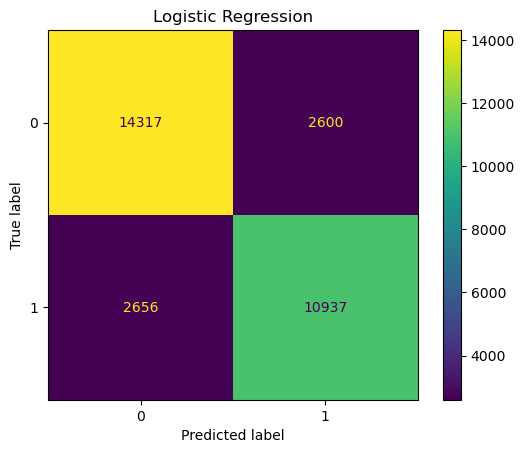

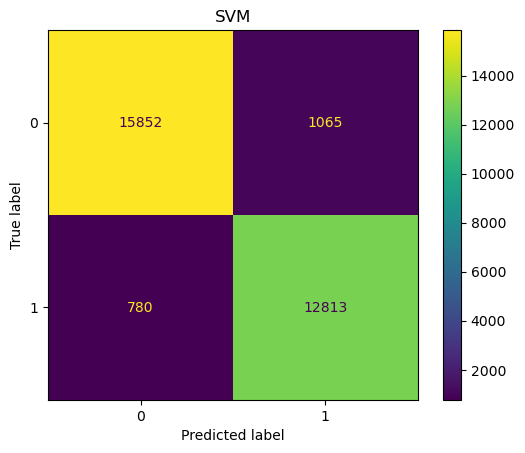

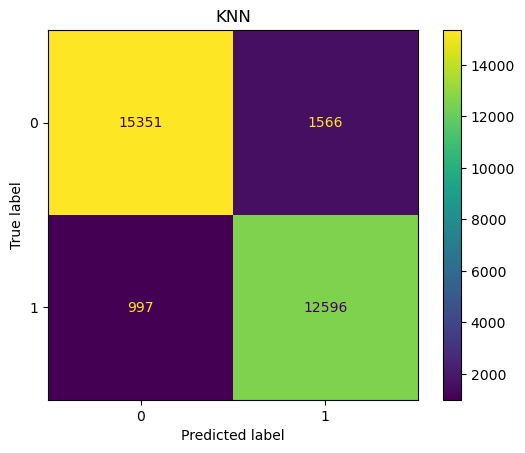

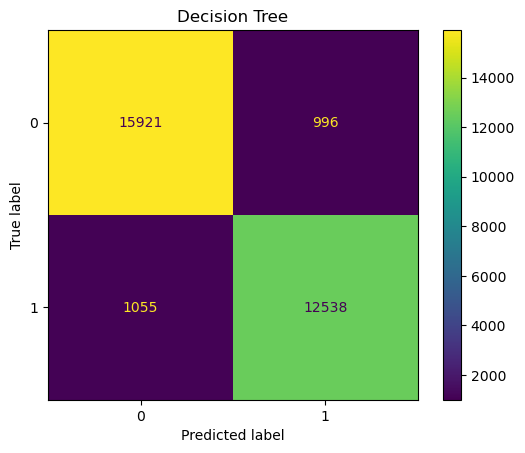

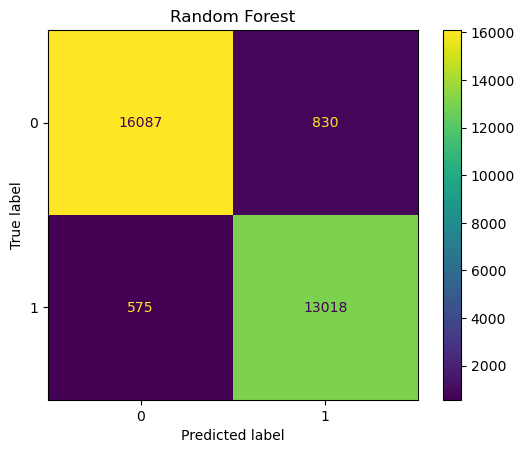

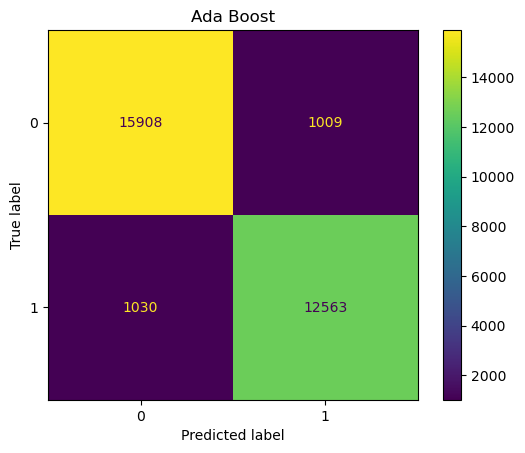

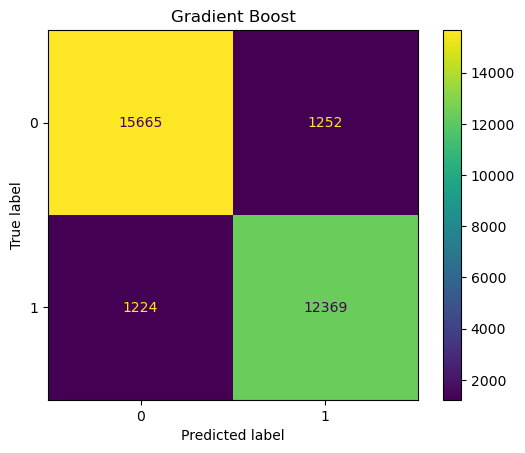

In [229]:
# Create a dictionary to store the results
results = {}

# List of models to test on the scaled data
models = [
    {
        'model': LogisticRegression(max_iter=5000),
        'key': 'Logistic Regression'
    },
    {
        'model': SVC(),
        'key': 'SVM'
    },
    {
        'model': KNeighborsClassifier(),
        'key': 'KNN'
    },
    {
        'model': DecisionTreeClassifier(),
        'key': 'Decision Tree'
    },
    {
        'model': RandomForestClassifier(oob_score=True),
        'key': 'Random Forest'
    },
    {
        'model': AdaBoostClassifier(estimator=DecisionTreeClassifier(), algorithm='SAMME'),
        'key': 'Ada Boost'
    },
    {
        'model': GradientBoostingClassifier(),
        'key': 'Gradient Boost'
    },
]


for i, model in enumerate(models):
    key = model['key']
    print('Analyzing model: ', model['key'])
    mdl = model['model']
    start_t = time.time()
    mdl.fit(x_train.values, y_train)
    models[i]['fitted_pipe']= mdl

    end_t = time.time()
    y_pred_train = mdl.predict(x_train.values)
    y_pred_test = mdl.predict(x_test.values)
    print(f'Confusion Matrix for {key}: \n')
    cm = confusion_matrix(y_test, y_pred_test, labels=mdl.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mdl.classes_)
    disp.plot()
    disp.ax_.set_title(model['key'])


    results[key] = {
        'score': mdl.score(x_test.values, y_test),
        'train_time': end_t - start_t,
        'train_accuracy': accuracy_score(y_train, y_pred_train),
        'test_accuracy': accuracy_score(y_test, y_pred_test),
        'train_f1': f1_score(y_train, y_pred_train, average='weighted', labels=np.unique(y_pred_train)),
        'test_f1': f1_score(y_test, y_pred_test, average='weighted', labels=np.unique(y_pred_test))
    }
    print(classification_report(y_test, y_pred_test, labels=np.unique(y_pred_test)))


                        score  train_time  train_accuracy  test_accuracy  \
Model                                                                      
Logistic Regression  0.827729    0.146556        0.829988       0.827729   
SVM                  0.939528   15.474836        0.945034       0.939528   
KNN                  0.915995    0.036508        0.943493       0.915995   
Decision Tree        0.932776    0.594009        1.000000       0.932776   
Random Forest        0.953950    4.179224        1.000000       0.953950   
Ada Boost            0.933169    0.614525        1.000000       0.933169   
Gradient Boost       0.918846   12.820457        0.920397       0.918846   

                     train_f1   test_f1  
Model                                    
Logistic Regression  0.829969  0.827693  
SVM                  0.945075  0.939585  
KNN                  0.943576  0.916137  
Decision Tree        1.000000  0.932762  
Random Forest        1.000000  0.953989  
Ada Boost            

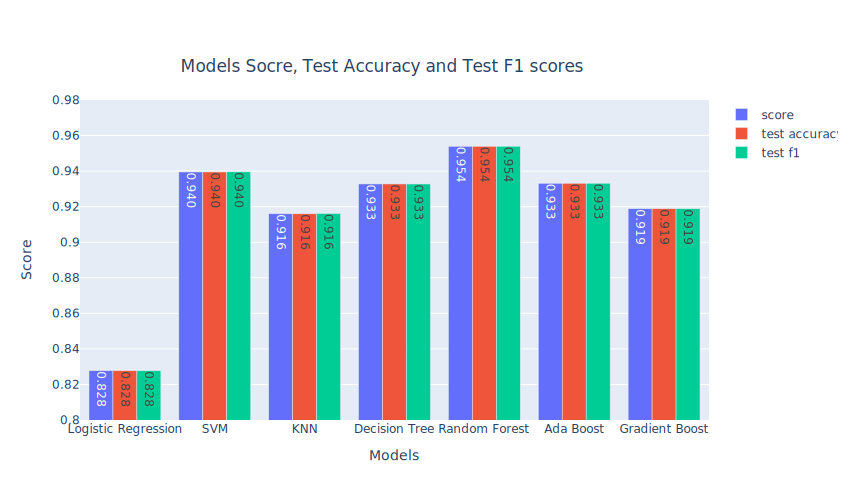

In [230]:
# Create a DataFrame to display results
df_results = pd.DataFrame(results).transpose()
df_results.index.name = 'Model'
print(df_results)

# Display the display results with Plotly
fig = go.Figure(data=[
    go.Bar(name='score', x=df_results.index, y=df_results.score, text=df_results.score),
    go.Bar(name='test accuracy', x=df_results.index, y=df_results.test_accuracy, text=df_results.test_accuracy),
    go.Bar(name='test f1', x=df_results.index, y=df_results.test_f1, text=df_results.test_f1)])
fig.update_layout(title="Models Socre, Test Accuracy and Test F1 scores", title_x=0.45, title_y=0.88,
                  yaxis_title='Score', xaxis_title='Models', height=500, width=850, yaxis_range=[0.80,0.98])
fig.update_traces(texttemplate='%{y:.3f}')
fig.write_image("img/classification_results.png")
fig.show()

Since the satisfaction and dissatisfaction classes are fairly balanced, and since we don't place significant emphasis on misclassification (recall or precision), but rather prioritize achieving accurate classification, we will focus on the `accuracy` metric for comparing the different classification models. With that in mind, the best classifier boasting the highest test classification accuracy is the `RandomForestClassifier`, achieving an accuracy of `95.54%`. Following closely in second place is `SVM` with a test accuracy of `94.1%`.

#### RandomForest OOB score (using the whole data set)

In [231]:
# Trying to use the whole dataset and use out-of-bag samples to estimate the generalization score
rf = RandomForestClassifier(oob_score=True)
rf.fit(X, y)
print(rf.oob_score_)

0.9547439752865887


When training RandomForestClassifier with the whole data set and using the out-of-bag samples to estimate the generalization score,  the test accuracy is `95.55%`. This is very similar to the one we recieved when training the model on the split train/test sets, which produced `95.54%` test accuracy. 

#### GridSearchCV with leading models
We'll pick the best proforming models from EDA and run GridSearchCV in hope to improve out test accuracy score

In [55]:
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

Grid_CV_results  = {}

# Define the hyperparameters grid
grid_search_mdl = [{
      'key': 'RandomForestClassifier',
      'model' : RandomForestClassifier(),
      'param_grid': {
        'n_estimators': [200, 300],        # Number of trees in the forest
        'max_depth': [None, 20],           # Maximum depth of the tree
        'max_features': ["sqrt", "log2"],  # The number of features to consider when looking for the best split
        }
    },
    {
      'key': 'AdaBoostClassifier',
      'model' : AdaBoostClassifier(),
      'param_grid' : {
        'n_estimators': [200, 300],        # Number of trees in the forest
        'learning_rate': [0.7, 1.0, 1.3],  # Learning rate
      }
    },
    {
      'key': 'DecisionTreeClassifier',
      'model' : DecisionTreeClassifier(),
      'param_grid' : {
        'criterion': ['gini', 'entropy'],  # The function to measure the quality of a split
        'splitter': ['best', 'random'],    # The strategy used to choose the split at each node
        'max_depth': [None, 25],           # Maximum depth of the tree
      }
    },
    {
      'key': 'SVM',
      'model': SVC(),
      'param_grid' : {
        'kernel': ['linear', 'rbf'],  # Kernel type
        'gamma': ['scale', 'auto']  # Kernel coefficient
      }
    }
]

for mdl in grid_search_mdl:
  print(f'Analyzing model: {mdl["key"]}')

  # Create GridSearchCV
  grid_search = GridSearchCV(estimator=mdl['model'], param_grid=mdl['param_grid'], cv=5, n_jobs=-1, verbose=2)

  start_time = time.time()

  # Fit the grid search to the data
  grid_search.fit(x_train.values, y_train)

  train_time = time.time() - start_time

  print("Best parameters found:", grid_search.best_params_)

  # Print the best score found
  print("Best score found:", grid_search.best_score_)

  best_model = grid_search.best_estimator_

  # Make predictions on test data
  y_pred_test = best_model.predict(x_test.values)

  # Evaluate accuracy
  test_accuracy = accuracy_score(y_test, y_pred_test)
  print("Accuracy on test data:", test_accuracy)

  # Print the best parameters found
  Grid_CV_results[mdl['key']] = {
      'train_time': train_time,
      'best_params': grid_search.best_params_,
      'best_score': grid_search.best_score_,
      'test_accuracy': test_accuracy
  }
  print(classification_report(y_test, y_pred_test, labels=np.unique(y_pred_test)))

Analyzing model: RandomForestClassifier
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 300}
Best score found: 0.9548372666748822
Accuracy on test data: 0.9565560255215427
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     15459
           1       0.94      0.96      0.95     12439

    accuracy                           0.96     27898
   macro avg       0.96      0.96      0.96     27898
weighted avg       0.96      0.96      0.96     27898

Analyzing model: AdaBoostClassifier
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/ben/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ben/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ben/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ben/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorit

Best parameters found: {'learning_rate': 1.0, 'n_estimators': 200}
Best score found: 0.901586329973507
Accuracy on test data: 0.9048318875905083
              precision    recall  f1-score   support

           0       0.92      0.91      0.91     15459
           1       0.89      0.90      0.89     12439

    accuracy                           0.90     27898
   macro avg       0.90      0.90      0.90     27898
weighted avg       0.90      0.90      0.90     27898

Analyzing model: DecisionTreeClassifier
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found: {'criterion': 'entropy', 'max_depth': 25, 'splitter': 'best'}
Best score found: 0.9375284366338962
Accuracy on test data: 0.9399240088895261
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     15459
           1       0.93      0.94      0.93     12439

    accuracy                           0.94     27898
   macro avg       0.94      0.94      0.94   

In [99]:
# Create a DataFrame to display Grid_CV_results
df_results = pd.DataFrame(Grid_CV_results).transpose()
df_results

train_time  \
RandomForestClassifier   194.349538   
AdaBoostClassifier       232.684342   
DecisionTreeClassifier      7.32519   
SVM                     2393.979941   

                                                              best_params  \
RandomForestClassifier  {'max_depth': None, 'max_features': 'sqrt', 'n...   
AdaBoostClassifier            {'learning_rate': 1.0, 'n_estimators': 200}   
DecisionTreeClassifier  {'criterion': 'entropy', 'max_depth': 25, 'spl...   
SVM                                   {'gamma': 'scale', 'kernel': 'rbf'}   

                       best_score test_accuracy  
RandomForestClassifier   0.954837      0.956556  
AdaBoostClassifier       0.901586      0.904832  
DecisionTreeClassifier   0.937528      0.939924  
SVM                      0.937973      0.941322

                         train_time  \
Model                                 
RandomForestClassifier   194.349538   
AdaBoostClassifier       232.684342   
DecisionTreeClassifier      7.32519   
SVM                     2393.979941   

                                                              best_params  \
Model                                                                       
RandomForestClassifier  {'max_depth': None, 'max_features': 'sqrt', 'n...   
AdaBoostClassifier            {'learning_rate': 1.0, 'n_estimators': 200}   
DecisionTreeClassifier  {'criterion': 'entropy', 'max_depth': 25, 'spl...   
SVM                                   {'gamma': 'scale', 'kernel': 'rbf'}   

                       best_score test_accuracy  
Model                                            
RandomForestClassifier   0.954837      0.956556  
AdaBoostClassifier       0.901586      0.904832  
DecisionTreeClassifier   0.937528      0.939924  
SVM                      0.937973      0.941322  


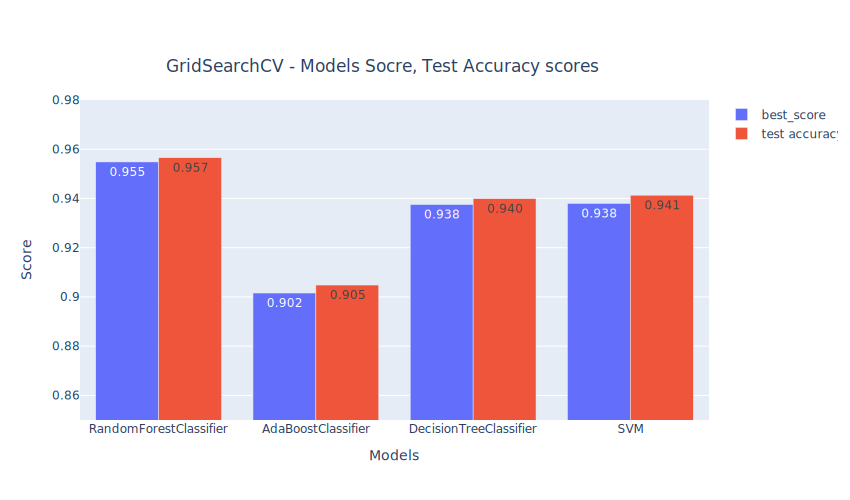

In [100]:
df_results.index.name = 'Model'
print(df_results)
# Display the display results with Plotly
fig = go.Figure(data=[
    go.Bar(name='best_score', x=df_results.index, y=df_results.best_score, text=df_results.best_score),
    go.Bar(name='test accuracy', x=df_results.index, y=df_results.test_accuracy, text=df_results.test_accuracy)
])
fig.update_layout(title="GridSearchCV - Models Socre, Test Accuracy scores", title_x=0.45, title_y=0.88,
                  yaxis_title='Score', xaxis_title='Models', height=500, width=850,  yaxis_range=[0.85, 0.98])
fig.update_traces(texttemplate='%{y:.3f}')
fig.write_image("img/gridsearch_results_classifiers.png")
fig.show()

Running GridSearchCV didn't improve much the results that we reieved from the initial model training. 
`RandomForestClassifier` model accuracy improved by a very small precentage and produced `95.7%` for best score and similar results for test accuracy, `95.55%`, compared the original accuracy of `95.66%`.`DecisionTreeClassifier`'s test accuracy improved from `93.5%` to `93.99%`, but it wasn't enough to make it the best model.

#### Feature Importance

First we'll use the feature importance from the leading model, RandemForest classifier

Top 10 most important features:


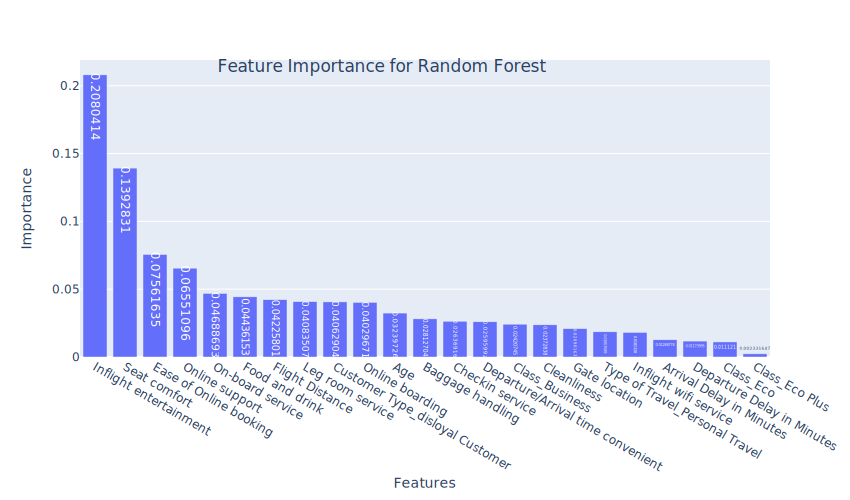

In [102]:
# We'll analyze feature importance of random forest
random_f = models[4]['fitted_pipe']
feature_importance = list(zip(list(x_train.columns), random_f.feature_importances_))
# Sort features by their importance (absolute coefficient value)
feature_importance.sort(key=lambda x: x[1], reverse=True)

feature_importances = {'feature': [], 'importance': []}
# Display the top 10 most important features
print(f"Top 10 most important features:")
for feature, importance in feature_importance:
    feature_importances['feature'].append(feature)
    feature_importances['importance'].append(importance)

df1 = pd.DataFrame(feature_importances)
fig = px.bar(df1, x='feature', y='importance', text_auto=True)
fig.update_layout(title=f'Feature Importance for Random Forest', title_x=0.45, title_y=0.88,
                yaxis_title='Importance', xaxis_title='Features', height=500, width=850)
fig.show()



We'll also calculate ***permutation importance*** from the fitted RandomForest model:

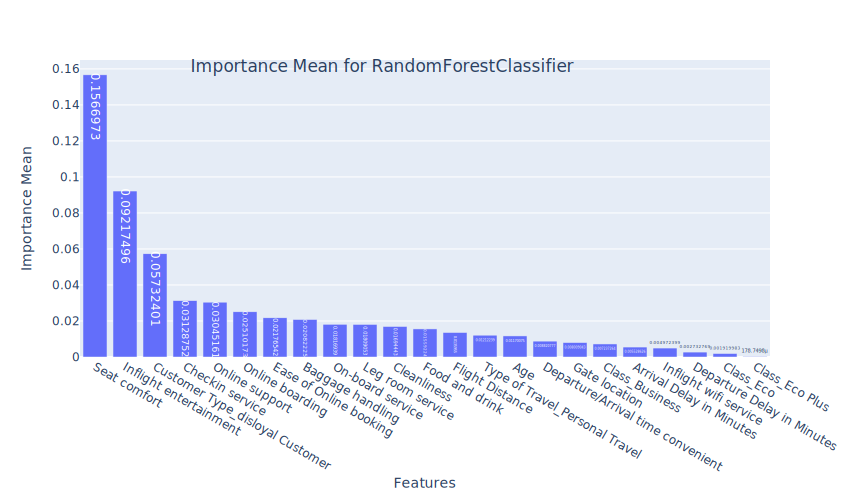

In [103]:
# define a generic function for calculating permutation importance
permutation_importance_results = {'feature': [], 'importance_mean': [], 'importance_std': [], 'model':[]}
def calc_permutation_importance(model, X, y, model_name, n_repeats=10, random_state=0):
  r = permutation_importance(model, X, y, n_repeats=10, random_state=0)
  for i in r.importances_mean.argsort()[::-1]:
      permutation_importance_results['feature'].append(X.columns.tolist()[i])
      permutation_importance_results['importance_mean'].append(r.importances_mean[i])
      permutation_importance_results['importance_std'].append(r.importances_std[i])
      permutation_importance_results['model'].append(model_name)

  df2 = pd.DataFrame(permutation_importance_results)
  df2[df2['model'] == model_name].head(20)
  fig = px.bar(df2[df2['model'] == model_name], x='feature', y='importance_mean', text_auto=True)
  fig.update_layout(title=f'Importance Mean for {model_name}', title_x=0.45, title_y=0.88,
                  yaxis_title='Importance Mean', xaxis_title='Features', height=500, width=850)
  fig.show()

calc_permutation_importance(random_f, x_train, y_train, 'RandomForestClassifier')

We can see that `Seat Comfort` and `Inflight Entrtainment` were the leading important features in both methods of analyzing the importance of the features.
We can also see that `Personal Travel` type and Disloyal Customer type had some importance (in a negative context). `Ease of Online Booking` also played part in customer satisfaction. Surprisingly, cleanliness didn't play a major part of the satisfaction.

#### Neural Networks - a Simple Network




In [ ]:
!pip install scikeras > /dev/null
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.regularizers import L1, L2
from scikeras.wrappers import KerasClassifier

In [ ]:
model = Sequential([
 Dense(256, activation='relu', input_shape=(x_train.shape[1],)),
 Dense(1, activation='sigmoid')
])
model.compile(optimizer='Adam',loss='bce', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy',mode='max', patience=10)
history_1 = model.fit(x_train, y_train,
                      epochs=100,
                      callbacks=[early_stopping],
                      validation_split=0.2)

Epoch 1/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8737 - loss: 0.2927 - val_accuracy: 0.9210 - val_loss: 0.1888
Epoch 2/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9236 - loss: 0.1823 - val_accuracy: 0.9303 - val_loss: 0.1662
Epoch 3/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9344 - loss: 0.1593 - val_accuracy: 0.9374 - val_loss: 0.1499
Epoch 4/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9395 - loss: 0.1453 - val_accuracy: 0.9404 - val_loss: 0.1394
Epoch 5/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9434 - loss: 0.1343 - val_accuracy: 0.9409 - val_loss: 0.1345
Epoch 6/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9454 - loss: 0.1264 - val_accuracy: 0.9419 - val_loss: 0.1293
Epoch 7/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9493 - loss: 0.1191 - val_accuracy: 0.9434 - val_loss: 0.1265
Epoch 8/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9500 - loss: 0

In [ ]:
history_1.model.summary()
model.evaluate(x_test, y_test)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,205 (75.02 KB)

 Trainable params: 6,401 (25.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,804 (50.02 KB)

595/595 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9455 - loss: 0.1326


[0.12552522122859955, 0.9493744373321533]

In [ ]:
accuracies = history_1.history['accuracy']
validation_accuracies = history_1.history['val_accuracy']

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(0, 46)), y=accuracies, mode='lines', name='Accuracy'))
fig.add_trace(go.Scatter(x=list(range(0, 46)), y=validation_accuracies, mode='lines', name='Validation Accuracy'))

fig.update_layout(title="Accuracy vs Validation Accuracy over Epochs", title_x=0.45, title_y=0.9,
                  yaxis_title='Accuracy', xaxis_title='Epoch', height=500, width=900)

fig.show()

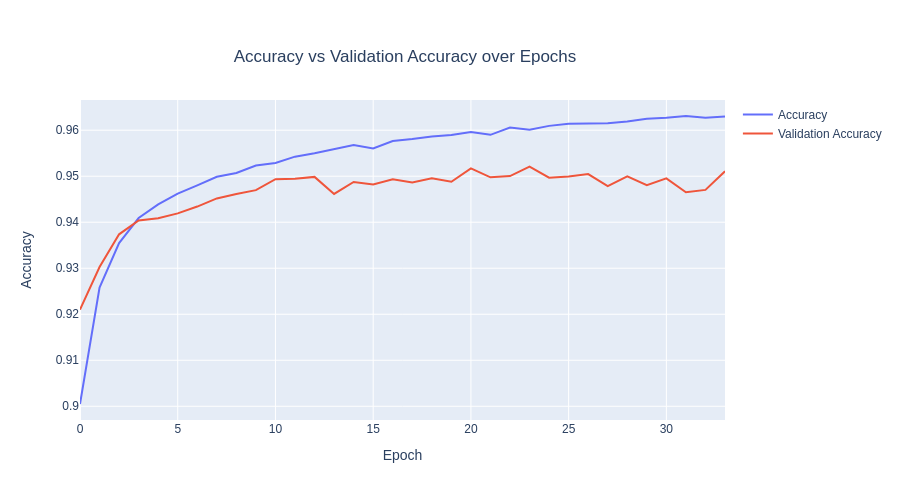

In [106]:
from IPython.display import Image
Image(filename='img/nn_1.png')

We can see that using a basic neural networks shows weaker model performance of `95.11%` accuracy, with peak of `95.2%` during model training (arouns epoc 20), when compared to the test accuracy of RandomForestClassifier with GridSearchCV (`95.65%`)

#### Neural Networks - more complex - with dropout regularization and more layers


In [ ]:
model_2 = Sequential([
 Dense(512, activation='relu', input_shape=(x_train.shape[1],)),
 Dropout(0.25),
 Dense(256, activation='relu'),
 Dropout(0.25),
 Dense(128, activation='relu'),
 Dense(1, activation='sigmoid')
])
model_2.compile(optimizer='Adam',loss='bce', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy',mode='max', patience=20)
history_2 = model_2.fit(x_train, y_train,
                      epochs=100,
                      callbacks=[early_stopping],
                      validation_split=0.2)

Epoch 1/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8856 - loss: 0.2626 - val_accuracy: 0.9371 - val_loss: 0.1487
Epoch 2/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9321 - loss: 0.1558 - val_accuracy: 0.9457 - val_loss: 0.1261
Epoch 3/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9435 - loss: 0.1304 - val_accuracy: 0.9434 - val_loss: 0.1319
Epoch 4/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9482 - loss: 0.1225 - val_accuracy: 0.9517 - val_loss: 0.1120
Epoch 5/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9504 - loss: 0.1130 - val_accuracy: 0.9525 - val_loss: 0.1059
Epoch 6/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9537 - loss: 0.1066 - val_accuracy: 0.9540 - val_loss: 0.1056
Epoch 7/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9540 - loss: 0.1031 - val_accuracy: 0.9544 - val_loss: 0.1022
Epoch 8/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9547 - loss: 

In [ ]:
history_2.model.summary()
model.evaluate(x_test, y_test)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 512)                 │          12,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 529,925 (2.02 MB)

 Trainable params: 176,641 (690.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 353,284 (1.35 MB)

595/595 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9455 - loss: 0.1326


[0.12552522122859955, 0.9493744373321533]

Using the more complex neural network with regularization (via drpouts), we improved the model accuracy to `95.83%`

In [ ]:
accuracies = history_2.history['accuracy']
validation_accuracies = history_2.history['val_accuracy']

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(0, 46)), y=accuracies, mode='lines', name='Accuracy'))
fig.add_trace(go.Scatter(x=list(range(0, 46)), y=validation_accuracies, mode='lines', name='Validation Accuracy'))

fig.update_layout(title="Accuracy vs Validation Accuracy over Epochs", title_x=0.45, title_y=0.9,
                  yaxis_title='Accuracy', xaxis_title='Epoch', height=500, width=900)

fig.show()


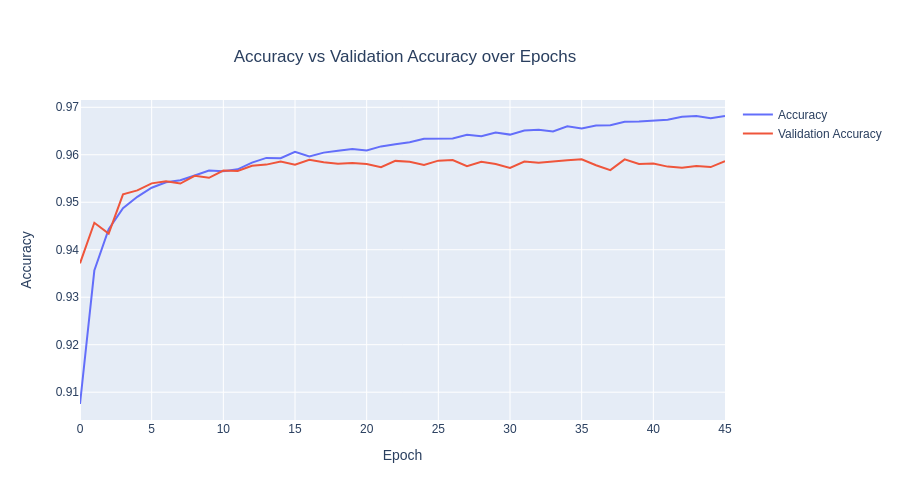

In [107]:
from IPython.display import Image

Image(filename='img/nn_2.png')

We can see that this model validation accuracy peaked at epoc 17 with `95.9%` accuracy and didn't improve much. We can see as the epoc number grows how the model slowly starts to overfit.

#### Neural Networks with KerasClassifier and GridSearchCV

In [ ]:
def build_function(neurons_1 = 1, neurons_2 = 1, neurons_3 = 1, dropout=0.3, loss_func="bce", optimizer=['rmsprop']):
    model = Sequential()
    model.add(Dense(units=neurons_1, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(Dropout(rate=0.3))
    model.add(Dense(units=neurons_2, activation='relu'))
    model.add(Dropout(rate=0.3))
    model.add(Dense(units=neurons_3, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss = loss_func, metrics = ['accuracy'])
    return model

In [ ]:
model_grid = KerasClassifier(build_fn=build_function,
                        epochs = 50,
                        callbacks=[EarlyStopping(monitor='accuracy',mode='max', patience=10)],
                        batch_size=256,
                        verbose = 1)

params = {'model__neurons_1': [256, 512],
          'model__neurons_2': [128],
          'model__neurons_3': [128, 64],
          'model__loss_func': ['binary_crossentropy', 'binary_focal_crossentropy'],
          'model__optimizer': ['Adam', 'rmsprop']}

grid_cv = GridSearchCV(model_grid, param_grid=params)
print(model_grid.get_params().keys())
grid_cv_fit = grid_cv.fit(x_train, y_train)
grid_score = grid_cv_fit.score(x_test, y_test)
grid_score

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'class_weight'])
Epoch 1/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8399 - loss: 0.3591
Epoch 2/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9025 - loss: 0.2269
Epoch 3/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9167 - loss: 0.1948
Epoch 4/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9265 - loss: 0.1766
Epoch 5/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9318 - loss: 0.1598
Epoch 6/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9351 - loss: 0.1514
Epoch 7/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9381 - loss: 0.1413
Epoch 8/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9426 - loss: 0.1347
Epoch 9/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9445 - loss: 0.

0.9574474796542805

In [ ]:
print(grid_cv_fit.best_params_)
print(grid_cv_fit.best_score_)
print(grid_cv_fit.best_estimator_)

{'model__loss_func': 'binary_crossentropy', 'model__neurons_1': 512, 'model__neurons_2': 128, 'model__neurons_3': 128}
0.9580779138846539
KerasClassifier(
	model=None
	build_fn=<function build_function at 0x7ae7b45de320>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=256
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7ae671e5dff0>]
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
	class_weight=None
	model__loss_func=binary_crossentropy
	model__neurons_1=512
	model__neurons_2=128
	model__neurons_3=128
)


We can see that GridSearchCV for NN didn't improved the model test accuracy `95.80%` (peak at `95.90%`) compared to `95.83%` for the complex NN model, and both presented a very similar accuracy at peak of NN model training

Best grid params were:

loss_func: binary_crossentropy<br>
First layer neurons count:  512<br>
Second layer neurons count: 128<br>
Third layer neurons count:  128<br>



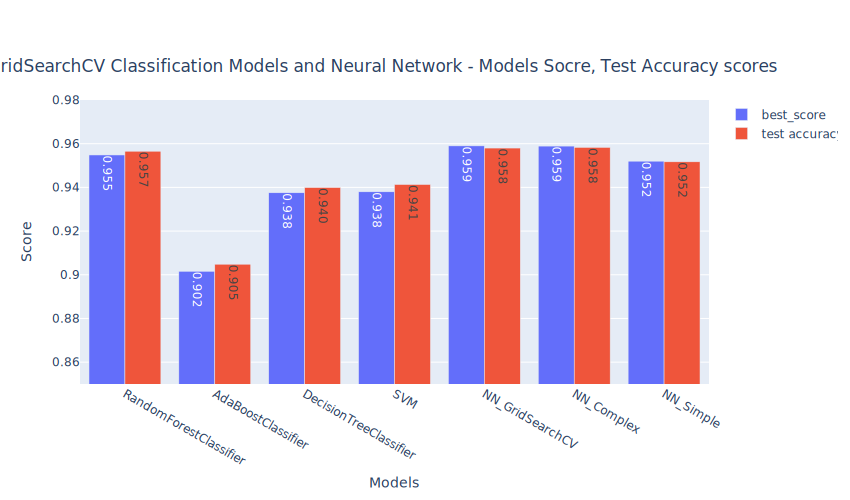

In [83]:
# Create a DataFrame to display Grid_CV_results
df_results = pd.DataFrame(Grid_CV_results).transpose()
df_results.index.name = 'Model'

# Display the display results with Plotly
fig = go.Figure(data=[
    go.Bar(name='best_score', x=df_results.index, y=df_results.best_score, text=df_results.best_score),
    go.Bar(name='test accuracy', x=df_results.index, y=df_results.test_accuracy, text=df_results.test_accuracy)
])
fig.update_layout(title="GridSearchCV Classification Models and Neural Network - Models Socre, Test Accuracy scores", title_x=0.45, title_y=0.88,
                  yaxis_title='Score', xaxis_title='Models', height=500, width=850, yaxis_range=[0.85,0.98])
fig.update_traces(texttemplate='%{y:.3f}')
fig.write_image("img/results_final.png")
fig.show()

**Selecting the best model**

After taking into account the accuracy as the main scoring metrics and evaluating the confusion matrices, it would be logical to pick Neural Networks Complex as the best model. It has the highest accuracy score of `95.83%`. Given more computational resources, I'm sure we can improve this score by fine-tuning this model with a larger variaty of GridSearchCV grid params.